<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/GANaugmentAt50Percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Augmentation

Predictors used:

* Decsion Tree
* Gradient Booster
* Neural Network
* LSTM


In [1]:
!pip install lasio
!pip install md_toc
!pip install tensorflow
!pip install tensorflow-addons
!pip install smogn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 746.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 865.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

from sklearn.svm import OneClassSVM

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam

from keras import layers
from keras import models

import tensorflow as tf
from tqdm import tqdm

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Fetching Data

In [4]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git

Cloning into 'Volve-Well-Log-Prediction'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 134 (delta 55), reused 9 (delta 3), pack-reused 0
Receiving objects: 100% (134/134), 64.62 MiB | 12.37 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [5]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,PEF,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT
0,188.5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,188.7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepareing Data

In [6]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1.head()

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT
24115,2600.0,0.371,2.356,82.748,1.323,7.126,8.648,104.605
24116,2600.1,0.341,2.338,79.399,1.196,6.654,8.578,103.827
24117,2600.2,0.308,2.315,74.248,1.171,6.105,8.578,102.740
24118,2600.3,0.283,2.291,68.542,1.142,5.613,8.547,100.943
24119,2600.4,0.272,2.269,60.314,1.107,5.281,8.523,98.473


In [7]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
24115,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
24116,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
24117,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
24118,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
24119,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4


## Dropping Data

In [8]:
num_rows_to_drop = int(0.5 * len(train))

# Randomly sample rows to drop
rows_to_drop = train.sample(n=num_rows_to_drop)

train_og = train.copy()

# Drop the sampled rows from the DataFrame
train = train.drop(rows_to_drop.index)
train_preserve = train.copy()

In [9]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

## Data Transformation and Normalization

In [10]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.672981,-0.771618,1.188393,-0.509092,0.135585,0.0,1.55161,15_9-F-11A,2600.0
1,1.529255,-0.873416,1.148859,-0.608062,-0.249356,-0.0,1.523569,15_9-F-11A,2600.1
2,1.347425,-0.998884,1.08469,-0.628882,-0.682823,-0.0,1.48351,15_9-F-11A,2600.2
3,1.115333,-1.234953,0.886004,-0.684455,-1.303327,-0.0,1.31562,15_9-F-11A,2600.4
4,1.236187,-1.331675,0.495961,-0.616333,-1.06601,-0.0,1.030699,15_9-F-11A,2600.8


In [11]:
# Log transform the RT to logarithmic
train_og['RT'] = np.log10(train_og['RT'])

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_og_trans = ct.fit_transform(train_og)

# Convert to dataframe
train_og_trans = pd.DataFrame(train_og_trans, columns=colnames)

## Outlier Removal

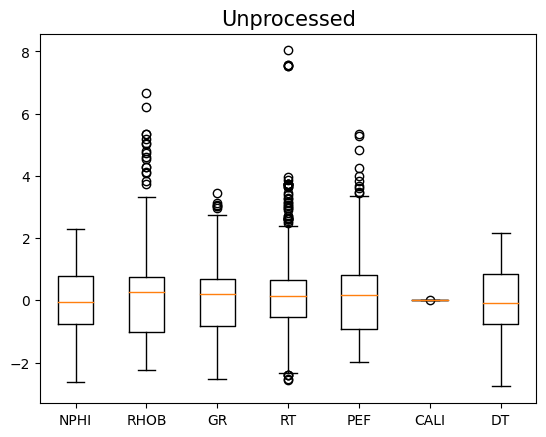

n samples unprocessed: 5250


In [12]:
# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

In [13]:
# Make a copy of train_og
train_og_fonly = train_og_trans.copy()

# Remove WELL, DEPTH
train_og_fonly = train_og_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_og_fonly_names = train_og_fonly.columns


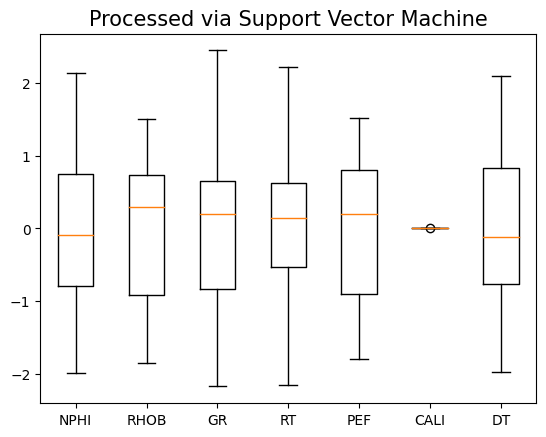

Remaining samples: 4727


In [14]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Processed via Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

In [15]:
# Define the OneClassSVM model
svm = OneClassSVM(nu=0.1)

# Predict outliers using OneClassSVM on train_og_fonly
yhat_og = svm.fit_predict(train_og_fonly)

# Create a mask to filter out the outliers
mask_og = yhat_og != -1

# Filter out the outliers from train_og_fonly
train_og_svm = train_og_fonly[mask_og]

In [16]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target_name = 'DT'


## Train and Validation Prep

In [17]:
# Select columns for features (X) and target (y)
X_train = train_svm[feature_names].values.astype('float32')
y_train = train_svm[target_name].values.reshape(-1, 1).astype('float32')

# Define the validation data
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
    # Split the df by log name
    val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]].copy()

    # Drop name column
    val.drop(['WELL'], axis=1, inplace=True)

    # Define X_val (feature) and y_val (target) as NumPy arrays
    X_val_ = val[feature_names].values.astype('float32')
    y_val_ = val[target_name].values.reshape(-1, 1).astype('float32')

    X_val.append(X_val_)
    y_val.append(y_val_)

# Save into separate NumPy arrays
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val

In [18]:
X_train = X_train.astype('float32')

# Cast y_train to float32
y_train = y_train.astype('float32')

# Cast X_val1, X_val3, X_val4 to float32
X_val1 = X_val1.astype('float32')
X_val3 = X_val3.astype('float32')
X_val4 = X_val4.astype('float32')

# Cast y_val1, y_val3, y_val4 to float32
y_val1 = y_val1.astype('float32')
y_val3 = y_val3.astype('float32')
y_val4 = y_val4.astype('float32')

## Data Augmentation

In [19]:
# Select columns for features (X) and target (y)
train_total = pd.merge(train_svm, train_trans, on = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT'], how='left')
train_gen = train_og_svm.copy()

In [20]:
train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

df_gen1 = train_total[train_total['WELL'] == '15_9-F-11A'].copy()
df_gen3 = train_total[train_total['WELL'] == '15_9-F-1A'].copy()
df_gen4 = train_total[train_total['WELL'] == '15_9-F-1B'].copy()

In [21]:
# # Fit and transform the 'DEPTH' column for df_gen1
# df_gen1['DEPTH'] = scaler.fit_transform(df_gen1[['DEPTH']])

# # Fit and transform the 'DEPTH' column for df_gen3
# df_gen3['DEPTH'] = scaler.fit_transform(df_gen3[['DEPTH']])

# # Fit and transform the 'DEPTH' column for df_gen4
# df_gen4['DEPTH'] = scaler.fit_transform(df_gen4[['DEPTH']])

In [22]:
df_gen1.drop(columns = 'WELL').astype('float32').describe()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,DEPTH
count,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2.440000e+03,2440.000000,2440.000000
mean,0.012180,-0.075615,-0.129860,-0.012427,0.161157,4.785277e-16,0.036046,3118.820068
std,0.996156,0.962849,0.937483,0.916429,1.034055,3.084110e-15,1.032293,357.956329
min,-1.886968,-1.843348,-2.145582,-2.157685,-1.657860,-7.105427e-15,-1.979222,2600.000000
25%,-0.826577,-1.196527,-0.929557,-0.464440,-0.914712,3.469447e-16,-0.817409,2802.625061
50%,-0.099608,0.271710,0.087552,0.197649,0.531081,3.469447e-16,-0.095214,3061.750000
75%,0.834484,0.738377,0.558712,0.661221,1.129396,3.441691e-15,0.897475,3462.249939
max,2.106062,1.438362,2.399066,2.217917,1.516734,9.880985e-15,2.063020,3720.000000


In [23]:
# Define the GAN model architecture
def build_generator(latent_dim, num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(256, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(256, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(num_features, activation='linear'))  # Output layer
    return model

def build_discriminator(num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_shape=(num_features,), activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(256, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(256, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer
    return model



In [24]:
generator_loss_fn =  tf.keras.losses.BinaryFocalCrossentropy()
discriminator_loss =  tf.keras.losses.BinaryFocalCrossentropy()


In [25]:
def train_gan(generator, discriminator, epochs, batch_size, data_frame, generator_optimizer, discriminator_optimizer):
    data_frame = data_frame

    # Determine the number of batches
    num_samples = len(data_frame)
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        avg_gen_loss = 0
        avg_disc_loss = 0
        with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:

            for batch in range(num_batches):

                # Get real data for the current batch
                batch_start = batch * batch_size
                batch_end = (batch + 1) * batch_size
                real_data = data_frame.iloc[batch_start:batch_end]
                real_data = real_data.values.astype('float32')

                # Sample random noise for generator input
                noise = np.random.uniform(-1, 1, size=(len(real_data), latent_dim))

                # Generate synthetic data
                generated_data = generator.predict(noise,  verbose=0)

                # Combine real and generated data
                x_combined = np.concatenate([real_data, generated_data])

                # Labels for real and generated data
                y_real = np.ones((batch_size, 1))
                y_generated = np.zeros((batch_size, 1))
                y_combined = np.concatenate([y_real, y_generated])

                # Train discriminator
                with tf.GradientTape() as disc_tape:
                    # Forward pass: compute logits for real and fake samples
                    real_logits = discriminator(real_data, training=True)
                    fake_logits = discriminator(generated_data, training=True)

                    # Compute discriminator loss
                    real_labels = tf.ones_like(real_logits)
                    fake_labels = tf.zeros_like(fake_logits)
                    discriminator_loss_real = discriminator_loss(real_labels, real_logits)
                    discriminator_loss_fake = discriminator_loss(fake_labels, fake_logits)
                    discriminator_loss_total = (discriminator_loss_real + discriminator_loss_fake)

                # Compute gradients of discriminator loss with respect to discriminator trainable variables
                gradients_of_discriminator = disc_tape.gradient(discriminator_loss_total, discriminator.trainable_variables)

                # Update discriminator weights using optimizer
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

                with tf.GradientTape() as gen_tape:
                    # Generate fake samples using the generator
                    fake_samples = generator(noise, training=True)

                    # Compute generator loss
                    generator_loss = generator_loss_fn(real_labels, discriminator(fake_samples, training=True))

                # Compute gradients of generator loss with respect to generator trainable variables
                gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)

                # Update generator weights using optimizer
                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

                avg_disc_loss += discriminator_loss_total
                avg_gen_loss +=  generator_loss

                pbar.update(1)

            # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {avg_disc_loss/num_batches}, Generator Loss: {avg_gen_loss/num_batches}")


In [26]:
# Generate synthetic data for certain depths
def generate_synthetic_data(generator, num_samples):
    noise = np.random.uniform(-1, 1, size=(num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data


In [27]:
# Train the GAN
# Define GAN components

latent_dim = 256

num_features = len(train_gen.columns)

generator_1 = build_generator(latent_dim, num_features)
discriminator_1 = build_discriminator(num_features)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

epochs = 128
batch_size = 4096
num_batches = len(train_gen) // batch_size
train_gan(generator_1, discriminator_1, epochs, batch_size, train_gen, generator_optimizer, discriminator_optimizer)

Epoch 1/128: 100%|██████████| 5/5 [00:11<00:00,  2.22s/batch]


Epoch 1/128, Discriminator Loss: 0.7705243825912476, Generator Loss: 0.37355655431747437


Epoch 2/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 2/128, Discriminator Loss: 0.7361348867416382, Generator Loss: 0.3462248742580414


Epoch 3/128: 100%|██████████| 5/5 [00:03<00:00,  1.40batch/s]


Epoch 3/128, Discriminator Loss: 0.7027357816696167, Generator Loss: 0.3246123194694519


Epoch 4/128: 100%|██████████| 5/5 [00:02<00:00,  1.67batch/s]


Epoch 4/128, Discriminator Loss: 0.6688542366027832, Generator Loss: 0.30280154943466187


Epoch 5/128: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Epoch 5/128, Discriminator Loss: 0.6448302268981934, Generator Loss: 0.29019421339035034


Epoch 6/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 6/128, Discriminator Loss: 0.6205693483352661, Generator Loss: 0.28110113739967346


Epoch 7/128: 100%|██████████| 5/5 [00:03<00:00,  1.40batch/s]


Epoch 7/128, Discriminator Loss: 0.5988732576370239, Generator Loss: 0.2724958062171936


Epoch 8/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 8/128, Discriminator Loss: 0.5760263204574585, Generator Loss: 0.2625144422054291


Epoch 9/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 9/128, Discriminator Loss: 0.5546916723251343, Generator Loss: 0.25453847646713257


Epoch 10/128: 100%|██████████| 5/5 [00:02<00:00,  1.83batch/s]


Epoch 10/128, Discriminator Loss: 0.5415676832199097, Generator Loss: 0.25044602155685425


Epoch 11/128: 100%|██████████| 5/5 [00:03<00:00,  1.33batch/s]


Epoch 11/128, Discriminator Loss: 0.5262326002120972, Generator Loss: 0.2453422099351883


Epoch 12/128: 100%|██████████| 5/5 [00:02<00:00,  1.78batch/s]


Epoch 12/128, Discriminator Loss: 0.5145202875137329, Generator Loss: 0.24018505215644836


Epoch 13/128: 100%|██████████| 5/5 [00:02<00:00,  1.75batch/s]


Epoch 13/128, Discriminator Loss: 0.504582405090332, Generator Loss: 0.23855642974376678


Epoch 14/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Epoch 14/128, Discriminator Loss: 0.4944278597831726, Generator Loss: 0.23397855460643768


Epoch 15/128: 100%|██████████| 5/5 [00:03<00:00,  1.38batch/s]


Epoch 15/128, Discriminator Loss: 0.485320508480072, Generator Loss: 0.23077723383903503


Epoch 16/128: 100%|██████████| 5/5 [00:03<00:00,  1.64batch/s]


Epoch 16/128, Discriminator Loss: 0.4790470004081726, Generator Loss: 0.22956375777721405


Epoch 17/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 17/128, Discriminator Loss: 0.4723580777645111, Generator Loss: 0.22772645950317383


Epoch 18/128: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Epoch 18/128, Discriminator Loss: 0.46649569272994995, Generator Loss: 0.22508415579795837


Epoch 19/128: 100%|██████████| 5/5 [00:03<00:00,  1.25batch/s]


Epoch 19/128, Discriminator Loss: 0.4630638062953949, Generator Loss: 0.2222030907869339


Epoch 20/128: 100%|██████████| 5/5 [00:02<00:00,  1.83batch/s]


Epoch 20/128, Discriminator Loss: 0.4593735337257385, Generator Loss: 0.22019314765930176


Epoch 21/128: 100%|██████████| 5/5 [00:05<00:00,  1.05s/batch]


Epoch 21/128, Discriminator Loss: 0.4562525749206543, Generator Loss: 0.21942751109600067


Epoch 22/128: 100%|██████████| 5/5 [00:03<00:00,  1.33batch/s]


Epoch 22/128, Discriminator Loss: 0.45135703682899475, Generator Loss: 0.21742753684520721


Epoch 23/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Epoch 23/128, Discriminator Loss: 0.4468669891357422, Generator Loss: 0.21641337871551514


Epoch 24/128: 100%|██████████| 5/5 [00:02<00:00,  1.75batch/s]


Epoch 24/128, Discriminator Loss: 0.44469594955444336, Generator Loss: 0.21505248546600342


Epoch 25/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 25/128, Discriminator Loss: 0.43998757004737854, Generator Loss: 0.2130974978208542


Epoch 26/128: 100%|██████████| 5/5 [00:03<00:00,  1.50batch/s]


Epoch 26/128, Discriminator Loss: 0.43792724609375, Generator Loss: 0.21191129088401794


Epoch 27/128: 100%|██████████| 5/5 [00:02<00:00,  1.72batch/s]


Epoch 27/128, Discriminator Loss: 0.43479490280151367, Generator Loss: 0.2103571593761444


Epoch 28/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 28/128, Discriminator Loss: 0.4326718747615814, Generator Loss: 0.20929069817066193


Epoch 29/128: 100%|██████████| 5/5 [00:03<00:00,  1.59batch/s]


Epoch 29/128, Discriminator Loss: 0.4286003112792969, Generator Loss: 0.2069002091884613


Epoch 30/128: 100%|██████████| 5/5 [00:03<00:00,  1.52batch/s]


Epoch 30/128, Discriminator Loss: 0.4262392520904541, Generator Loss: 0.20689991116523743


Epoch 31/128: 100%|██████████| 5/5 [00:02<00:00,  1.85batch/s]


Epoch 31/128, Discriminator Loss: 0.42381373047828674, Generator Loss: 0.205680251121521


Epoch 32/128: 100%|██████████| 5/5 [00:02<00:00,  1.82batch/s]


Epoch 32/128, Discriminator Loss: 0.42112088203430176, Generator Loss: 0.20420460402965546


Epoch 33/128: 100%|██████████| 5/5 [00:03<00:00,  1.53batch/s]


Epoch 33/128, Discriminator Loss: 0.4197663366794586, Generator Loss: 0.20375537872314453


Epoch 34/128: 100%|██████████| 5/5 [00:03<00:00,  1.62batch/s]


Epoch 34/128, Discriminator Loss: 0.41814762353897095, Generator Loss: 0.20285356044769287


Epoch 35/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 35/128, Discriminator Loss: 0.41646265983581543, Generator Loss: 0.20194701850414276


Epoch 36/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 36/128, Discriminator Loss: 0.41412991285324097, Generator Loss: 0.2010246068239212


Epoch 37/128: 100%|██████████| 5/5 [00:03<00:00,  1.59batch/s]


Epoch 37/128, Discriminator Loss: 0.4126358926296234, Generator Loss: 0.20169034600257874


Epoch 38/128: 100%|██████████| 5/5 [00:03<00:00,  1.57batch/s]


Epoch 38/128, Discriminator Loss: 0.4110245704650879, Generator Loss: 0.19996151328086853


Epoch 39/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 39/128, Discriminator Loss: 0.4094699025154114, Generator Loss: 0.19947676360607147


Epoch 40/128: 100%|██████████| 5/5 [00:02<00:00,  1.82batch/s]


Epoch 40/128, Discriminator Loss: 0.4078655242919922, Generator Loss: 0.19829508662223816


Epoch 41/128: 100%|██████████| 5/5 [00:04<00:00,  1.18batch/s]


Epoch 41/128, Discriminator Loss: 0.4063233435153961, Generator Loss: 0.1976347267627716


Epoch 42/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 42/128, Discriminator Loss: 0.4054667055606842, Generator Loss: 0.19717101752758026


Epoch 43/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Epoch 43/128, Discriminator Loss: 0.4036455750465393, Generator Loss: 0.19660000503063202


Epoch 44/128: 100%|██████████| 5/5 [00:02<00:00,  1.83batch/s]


Epoch 44/128, Discriminator Loss: 0.40234503149986267, Generator Loss: 0.19570797681808472


Epoch 45/128: 100%|██████████| 5/5 [00:03<00:00,  1.35batch/s]


Epoch 45/128, Discriminator Loss: 0.40135255455970764, Generator Loss: 0.195230633020401


Epoch 46/128: 100%|██████████| 5/5 [00:02<00:00,  1.72batch/s]


Epoch 46/128, Discriminator Loss: 0.4001882076263428, Generator Loss: 0.19503219425678253


Epoch 47/128: 100%|██████████| 5/5 [00:02<00:00,  1.69batch/s]


Epoch 47/128, Discriminator Loss: 0.39929530024528503, Generator Loss: 0.19434097409248352


Epoch 48/128: 100%|██████████| 5/5 [00:02<00:00,  1.70batch/s]


Epoch 48/128, Discriminator Loss: 0.3980570435523987, Generator Loss: 0.1942719966173172


Epoch 49/128: 100%|██████████| 5/5 [00:03<00:00,  1.39batch/s]


Epoch 49/128, Discriminator Loss: 0.39770835638046265, Generator Loss: 0.19366326928138733


Epoch 50/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 50/128, Discriminator Loss: 0.3970101475715637, Generator Loss: 0.19329717755317688


Epoch 51/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Epoch 51/128, Discriminator Loss: 0.39580345153808594, Generator Loss: 0.19266504049301147


Epoch 52/128: 100%|██████████| 5/5 [00:02<00:00,  1.82batch/s]


Epoch 52/128, Discriminator Loss: 0.3945578634738922, Generator Loss: 0.19223609566688538


Epoch 53/128: 100%|██████████| 5/5 [00:03<00:00,  1.39batch/s]


Epoch 53/128, Discriminator Loss: 0.3937366008758545, Generator Loss: 0.1917809545993805


Epoch 54/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 54/128, Discriminator Loss: 0.39299434423446655, Generator Loss: 0.1915341019630432


Epoch 55/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 55/128, Discriminator Loss: 0.39184510707855225, Generator Loss: 0.19099225103855133


Epoch 56/128: 100%|██████████| 5/5 [00:02<00:00,  1.79batch/s]


Epoch 56/128, Discriminator Loss: 0.39120563864707947, Generator Loss: 0.19073036313056946


Epoch 57/128: 100%|██████████| 5/5 [00:03<00:00,  1.32batch/s]


Epoch 57/128, Discriminator Loss: 0.3904484808444977, Generator Loss: 0.19028335809707642


Epoch 58/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 58/128, Discriminator Loss: 0.3899970054626465, Generator Loss: 0.19011470675468445


Epoch 59/128: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Epoch 59/128, Discriminator Loss: 0.3891940712928772, Generator Loss: 0.18979056179523468


Epoch 60/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 60/128, Discriminator Loss: 0.3884362280368805, Generator Loss: 0.18938864767551422


Epoch 61/128: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s]


Epoch 61/128, Discriminator Loss: 0.3879770040512085, Generator Loss: 0.18922874331474304


Epoch 62/128: 100%|██████████| 5/5 [00:02<00:00,  1.84batch/s]


Epoch 62/128, Discriminator Loss: 0.3872375190258026, Generator Loss: 0.18871958553791046


Epoch 63/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 63/128, Discriminator Loss: 0.38673099875450134, Generator Loss: 0.18847835063934326


Epoch 64/128: 100%|██████████| 5/5 [00:03<00:00,  1.64batch/s]


Epoch 64/128, Discriminator Loss: 0.3861263692378998, Generator Loss: 0.18843050301074982


Epoch 65/128: 100%|██████████| 5/5 [00:03<00:00,  1.49batch/s]


Epoch 65/128, Discriminator Loss: 0.3856440484523773, Generator Loss: 0.18795621395111084


Epoch 66/128: 100%|██████████| 5/5 [00:02<00:00,  1.84batch/s]


Epoch 66/128, Discriminator Loss: 0.3848630487918854, Generator Loss: 0.1875913143157959


Epoch 67/128: 100%|██████████| 5/5 [00:02<00:00,  1.78batch/s]


Epoch 67/128, Discriminator Loss: 0.3848147988319397, Generator Loss: 0.1876274049282074


Epoch 68/128: 100%|██████████| 5/5 [00:03<00:00,  1.46batch/s]


Epoch 68/128, Discriminator Loss: 0.3840813934803009, Generator Loss: 0.18725435435771942


Epoch 69/128: 100%|██████████| 5/5 [00:03<00:00,  1.50batch/s]


Epoch 69/128, Discriminator Loss: 0.38393840193748474, Generator Loss: 0.18775780498981476


Epoch 70/128: 100%|██████████| 5/5 [00:02<00:00,  1.79batch/s]


Epoch 70/128, Discriminator Loss: 0.3828049302101135, Generator Loss: 0.18699689209461212


Epoch 71/128: 100%|██████████| 5/5 [00:02<00:00,  1.83batch/s]


Epoch 71/128, Discriminator Loss: 0.3827191889286041, Generator Loss: 0.1867520809173584


Epoch 72/128: 100%|██████████| 5/5 [00:03<00:00,  1.56batch/s]


Epoch 72/128, Discriminator Loss: 0.3821287453174591, Generator Loss: 0.18663738667964935


Epoch 73/128: 100%|██████████| 5/5 [00:02<00:00,  1.67batch/s]


Epoch 73/128, Discriminator Loss: 0.38168954849243164, Generator Loss: 0.18647441267967224


Epoch 74/128: 100%|██████████| 5/5 [00:02<00:00,  1.85batch/s]


Epoch 74/128, Discriminator Loss: 0.3814123570919037, Generator Loss: 0.18633152544498444


Epoch 75/128: 100%|██████████| 5/5 [00:02<00:00,  1.82batch/s]


Epoch 75/128, Discriminator Loss: 0.3809668719768524, Generator Loss: 0.18599849939346313


Epoch 76/128: 100%|██████████| 5/5 [00:03<00:00,  1.61batch/s]


Epoch 76/128, Discriminator Loss: 0.38031405210494995, Generator Loss: 0.1857961118221283


Epoch 77/128: 100%|██████████| 5/5 [00:03<00:00,  1.53batch/s]


Epoch 77/128, Discriminator Loss: 0.37974902987480164, Generator Loss: 0.18570730090141296


Epoch 78/128: 100%|██████████| 5/5 [00:02<00:00,  1.83batch/s]


Epoch 78/128, Discriminator Loss: 0.3798142969608307, Generator Loss: 0.18593934178352356


Epoch 79/128: 100%|██████████| 5/5 [00:02<00:00,  1.84batch/s]


Epoch 79/128, Discriminator Loss: 0.37905219197273254, Generator Loss: 0.18554536998271942


Epoch 80/128: 100%|██████████| 5/5 [00:03<00:00,  1.56batch/s]


Epoch 80/128, Discriminator Loss: 0.37838253378868103, Generator Loss: 0.18504808843135834


Epoch 81/128: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 81/128, Discriminator Loss: 0.37800735235214233, Generator Loss: 0.18494963645935059


Epoch 82/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 82/128, Discriminator Loss: 0.37799057364463806, Generator Loss: 0.18460342288017273


Epoch 83/128: 100%|██████████| 5/5 [00:02<00:00,  1.75batch/s]


Epoch 83/128, Discriminator Loss: 0.37757009267807007, Generator Loss: 0.1847253143787384


Epoch 84/128: 100%|██████████| 5/5 [00:03<00:00,  1.62batch/s]


Epoch 84/128, Discriminator Loss: 0.37683090567588806, Generator Loss: 0.18461820483207703


Epoch 85/128: 100%|██████████| 5/5 [00:03<00:00,  1.56batch/s]


Epoch 85/128, Discriminator Loss: 0.3767431378364563, Generator Loss: 0.18458543717861176


Epoch 86/128: 100%|██████████| 5/5 [00:02<00:00,  1.78batch/s]


Epoch 86/128, Discriminator Loss: 0.37625136971473694, Generator Loss: 0.18396838009357452


Epoch 87/128: 100%|██████████| 5/5 [00:02<00:00,  1.69batch/s]


Epoch 87/128, Discriminator Loss: 0.37614426016807556, Generator Loss: 0.18430498242378235


Epoch 88/128: 100%|██████████| 5/5 [00:03<00:00,  1.41batch/s]


Epoch 88/128, Discriminator Loss: 0.3755750060081482, Generator Loss: 0.18387305736541748


Epoch 89/128: 100%|██████████| 5/5 [00:02<00:00,  1.70batch/s]


Epoch 89/128, Discriminator Loss: 0.3757255971431732, Generator Loss: 0.18414482474327087


Epoch 90/128: 100%|██████████| 5/5 [00:02<00:00,  1.78batch/s]


Epoch 90/128, Discriminator Loss: 0.3749002516269684, Generator Loss: 0.18351030349731445


Epoch 91/128: 100%|██████████| 5/5 [00:02<00:00,  1.82batch/s]


Epoch 91/128, Discriminator Loss: 0.3747221827507019, Generator Loss: 0.18354016542434692


Epoch 92/128: 100%|██████████| 5/5 [00:04<00:00,  1.24batch/s]


Epoch 92/128, Discriminator Loss: 0.3740966320037842, Generator Loss: 0.1833181232213974


Epoch 93/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 93/128, Discriminator Loss: 0.3741764426231384, Generator Loss: 0.18352878093719482


Epoch 94/128: 100%|██████████| 5/5 [00:02<00:00,  1.72batch/s]


Epoch 94/128, Discriminator Loss: 0.37361159920692444, Generator Loss: 0.18308381736278534


Epoch 95/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Epoch 95/128, Discriminator Loss: 0.37361574172973633, Generator Loss: 0.18312296271324158


Epoch 96/128: 100%|██████████| 5/5 [00:03<00:00,  1.37batch/s]


Epoch 96/128, Discriminator Loss: 0.37306371331214905, Generator Loss: 0.1829371452331543


Epoch 97/128: 100%|██████████| 5/5 [00:02<00:00,  1.70batch/s]


Epoch 97/128, Discriminator Loss: 0.372930109500885, Generator Loss: 0.18273313343524933


Epoch 98/128: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Epoch 98/128, Discriminator Loss: 0.3724135160446167, Generator Loss: 0.18265748023986816


Epoch 99/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 99/128, Discriminator Loss: 0.37247705459594727, Generator Loss: 0.18249931931495667


Epoch 100/128: 100%|██████████| 5/5 [00:03<00:00,  1.36batch/s]


Epoch 100/128, Discriminator Loss: 0.372043639421463, Generator Loss: 0.18247514963150024


Epoch 101/128: 100%|██████████| 5/5 [00:02<00:00,  1.75batch/s]


Epoch 101/128, Discriminator Loss: 0.3717781603336334, Generator Loss: 0.18237611651420593


Epoch 102/128: 100%|██████████| 5/5 [00:02<00:00,  1.89batch/s]


Epoch 102/128, Discriminator Loss: 0.3716428875923157, Generator Loss: 0.18240468204021454


Epoch 103/128: 100%|██████████| 5/5 [00:02<00:00,  1.78batch/s]


Epoch 103/128, Discriminator Loss: 0.37081265449523926, Generator Loss: 0.1819731444120407


Epoch 104/128: 100%|██████████| 5/5 [00:03<00:00,  1.41batch/s]


Epoch 104/128, Discriminator Loss: 0.3710004985332489, Generator Loss: 0.18192723393440247


Epoch 105/128: 100%|██████████| 5/5 [00:02<00:00,  1.85batch/s]


Epoch 105/128, Discriminator Loss: 0.37066125869750977, Generator Loss: 0.18165890872478485


Epoch 106/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 106/128, Discriminator Loss: 0.37045031785964966, Generator Loss: 0.181645467877388


Epoch 107/128: 100%|██████████| 5/5 [00:02<00:00,  1.69batch/s]


Epoch 107/128, Discriminator Loss: 0.37018078565597534, Generator Loss: 0.18174779415130615


Epoch 108/128: 100%|██████████| 5/5 [00:03<00:00,  1.40batch/s]


Epoch 108/128, Discriminator Loss: 0.3700927793979645, Generator Loss: 0.1815095990896225


Epoch 109/128: 100%|██████████| 5/5 [00:02<00:00,  1.79batch/s]


Epoch 109/128, Discriminator Loss: 0.3699325621128082, Generator Loss: 0.1814502775669098


Epoch 110/128: 100%|██████████| 5/5 [00:02<00:00,  1.82batch/s]


Epoch 110/128, Discriminator Loss: 0.3694272041320801, Generator Loss: 0.1811203509569168


Epoch 111/128: 100%|██████████| 5/5 [00:02<00:00,  1.75batch/s]


Epoch 111/128, Discriminator Loss: 0.36934223771095276, Generator Loss: 0.1811298131942749


Epoch 112/128: 100%|██████████| 5/5 [00:03<00:00,  1.45batch/s]


Epoch 112/128, Discriminator Loss: 0.36904746294021606, Generator Loss: 0.18101470172405243


Epoch 113/128: 100%|██████████| 5/5 [00:02<00:00,  1.78batch/s]


Epoch 113/128, Discriminator Loss: 0.36895084381103516, Generator Loss: 0.18095716834068298


Epoch 114/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Epoch 114/128, Discriminator Loss: 0.3687497079372406, Generator Loss: 0.1809150129556656


Epoch 115/128: 100%|██████████| 5/5 [00:02<00:00,  1.82batch/s]


Epoch 115/128, Discriminator Loss: 0.36829033493995667, Generator Loss: 0.1808461844921112


Epoch 116/128: 100%|██████████| 5/5 [00:03<00:00,  1.48batch/s]


Epoch 116/128, Discriminator Loss: 0.36828866600990295, Generator Loss: 0.18070010840892792


Epoch 117/128: 100%|██████████| 5/5 [00:02<00:00,  1.78batch/s]


Epoch 117/128, Discriminator Loss: 0.3679761290550232, Generator Loss: 0.1805669516324997


Epoch 118/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 118/128, Discriminator Loss: 0.36775413155555725, Generator Loss: 0.18048283457756042


Epoch 119/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 119/128, Discriminator Loss: 0.3676307201385498, Generator Loss: 0.18045885860919952


Epoch 120/128: 100%|██████████| 5/5 [00:03<00:00,  1.33batch/s]


Epoch 120/128, Discriminator Loss: 0.3676472306251526, Generator Loss: 0.1806856393814087


Epoch 121/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Epoch 121/128, Discriminator Loss: 0.3673197329044342, Generator Loss: 0.18042561411857605


Epoch 122/128: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Epoch 122/128, Discriminator Loss: 0.3670777380466461, Generator Loss: 0.18006250262260437


Epoch 123/128: 100%|██████████| 5/5 [00:02<00:00,  1.69batch/s]


Epoch 123/128, Discriminator Loss: 0.3668760657310486, Generator Loss: 0.18015356361865997


Epoch 124/128: 100%|██████████| 5/5 [00:03<00:00,  1.55batch/s]


Epoch 124/128, Discriminator Loss: 0.3664816617965698, Generator Loss: 0.17989486455917358


Epoch 125/128: 100%|██████████| 5/5 [00:02<00:00,  1.79batch/s]


Epoch 125/128, Discriminator Loss: 0.366639643907547, Generator Loss: 0.18003727495670319


Epoch 126/128: 100%|██████████| 5/5 [00:02<00:00,  1.83batch/s]


Epoch 126/128, Discriminator Loss: 0.366214781999588, Generator Loss: 0.1798444539308548


Epoch 127/128: 100%|██████████| 5/5 [00:02<00:00,  1.69batch/s]


Epoch 127/128, Discriminator Loss: 0.3661109507083893, Generator Loss: 0.1799531728029251


Epoch 128/128: 100%|██████████| 5/5 [00:03<00:00,  1.38batch/s]

Epoch 128/128, Discriminator Loss: 0.36607998609542847, Generator Loss: 0.17994484305381775


In [28]:
# Generate model summaries for generator_1 and discriminator_1
print("Generator Model Summary:")
generator_1.summary()

print("\nDiscriminator Model Summary:")
discriminator_1.summary()

Generator Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               65792     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (N

In [29]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_1 = generate_synthetic_data(generator_1, int(len(train)*0.15))

25/25 [==============================] - 0s 2ms/step


In [30]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_3 = generate_synthetic_data(generator_1, int(len(train)*0.15))

25/25 [==============================] - 0s 2ms/step


In [31]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_4 = generate_synthetic_data(generator_1, int(len(train)*0.15))

25/25 [==============================] - 0s 2ms/step


In [32]:
columns = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

synthetic_df_1 = pd.DataFrame(synthetic_data_1, columns=columns)
synthetic_df_3 = pd.DataFrame(synthetic_data_3, columns=columns)
synthetic_df_4 = pd.DataFrame(synthetic_data_4, columns=columns)


In [33]:
from sklearn.ensemble import GradientBoostingRegressor
boosters = {}

# Train gradient boosters for each well
for well_name, df_gen in zip(train_well_names, [df_gen1, df_gen3, df_gen4]):
    # Filter data for the current well
    # df_gen = train_total[train_total['WELL'] == well_name].copy()

    # Define features (X) and target (y)
    X = df_gen.drop(columns=['DEPTH', 'WELL'])  # Assuming 'DEPTH' and 'WELL' are not features
    y = df_gen['DEPTH']

    # Train gradient booster
    booster = GradientBoostingRegressor()
    booster.fit(X, y)

    # Store trained booster in the dictionary
    boosters[well_name] = booster

# Use trained boosters to predict 'DEPTH' values for synthetic data frames
for synthetic_df, well_name in zip([synthetic_df_1, synthetic_df_3, synthetic_df_4], train_well_names):
    # Get corresponding booster for the well
    booster = boosters[well_name]

    # Predict 'DEPTH' values for synthetic data
    synthetic_df['DEPTH'] = booster.predict(synthetic_df)

In [34]:
# scaler.fit(train_total[train_total['WELL'] == '15_9-F-11A']['DEPTH'].values.reshape(-1, 1))
# df_gen1['DEPTH'] = scaler.inverse_transform(df_gen1['DEPTH'].values.reshape(-1, 1))
# synthetic_df_1['DEPTH'] = scaler.inverse_transform(synthetic_df_1['DEPTH'].values.reshape(-1, 1))

# scaler.fit(train_total[train_total['WELL'] == '15_9-F-1A']['DEPTH'].values.reshape(-1, 1))
# df_gen3['DEPTH'] = scaler.inverse_transform(df_gen3['DEPTH'].values.reshape(-1, 1))
# synthetic_df_3['DEPTH'] = scaler.inverse_transform(synthetic_df_3['DEPTH'].values.reshape(-1, 1))


# scaler.fit(train_total[train_total['WELL'] == '15_9-F-1B']['DEPTH'].values.reshape(-1, 1))
# df_gen4['DEPTH'] = scaler.inverse_transform(df_gen4['DEPTH'].values.reshape(-1, 1))
# synthetic_df_4['DEPTH'] = scaler.inverse_transform(synthetic_df_4['DEPTH'].values.reshape(-1, 1))


In [35]:
def exponential_smoothing(series, alpha):
    smoothed_series = series.copy()
    for i in range(1, len(series)):
        smoothed_series[i] = alpha * series[i] + (1 - alpha) * smoothed_series[i - 1]
    return smoothed_series


In [36]:
# Define alpha for exponential smoothing (adjust as needed)
# alpha = 0.2

# # Apply sorting and exponential smoothing for each DataFrame
# for synthetic_df in [synthetic_df_1, synthetic_df_3, synthetic_df_4]:
#     synthetic_df.sort_values(by='DEPTH', inplace=True)
#     for column in synthetic_df.columns:
#         if column != 'WELL':  # Skip the 'WELL' column
#             synthetic_df[column] = exponential_smoothing(synthetic_df[column], alpha)

In [37]:
synthetic_df_1['WELL'] = '15_9-F-11A'
synthetic_df_3['WELL'] = '15_9-F-1A'
synthetic_df_4['WELL'] = '15_9-F-1B'

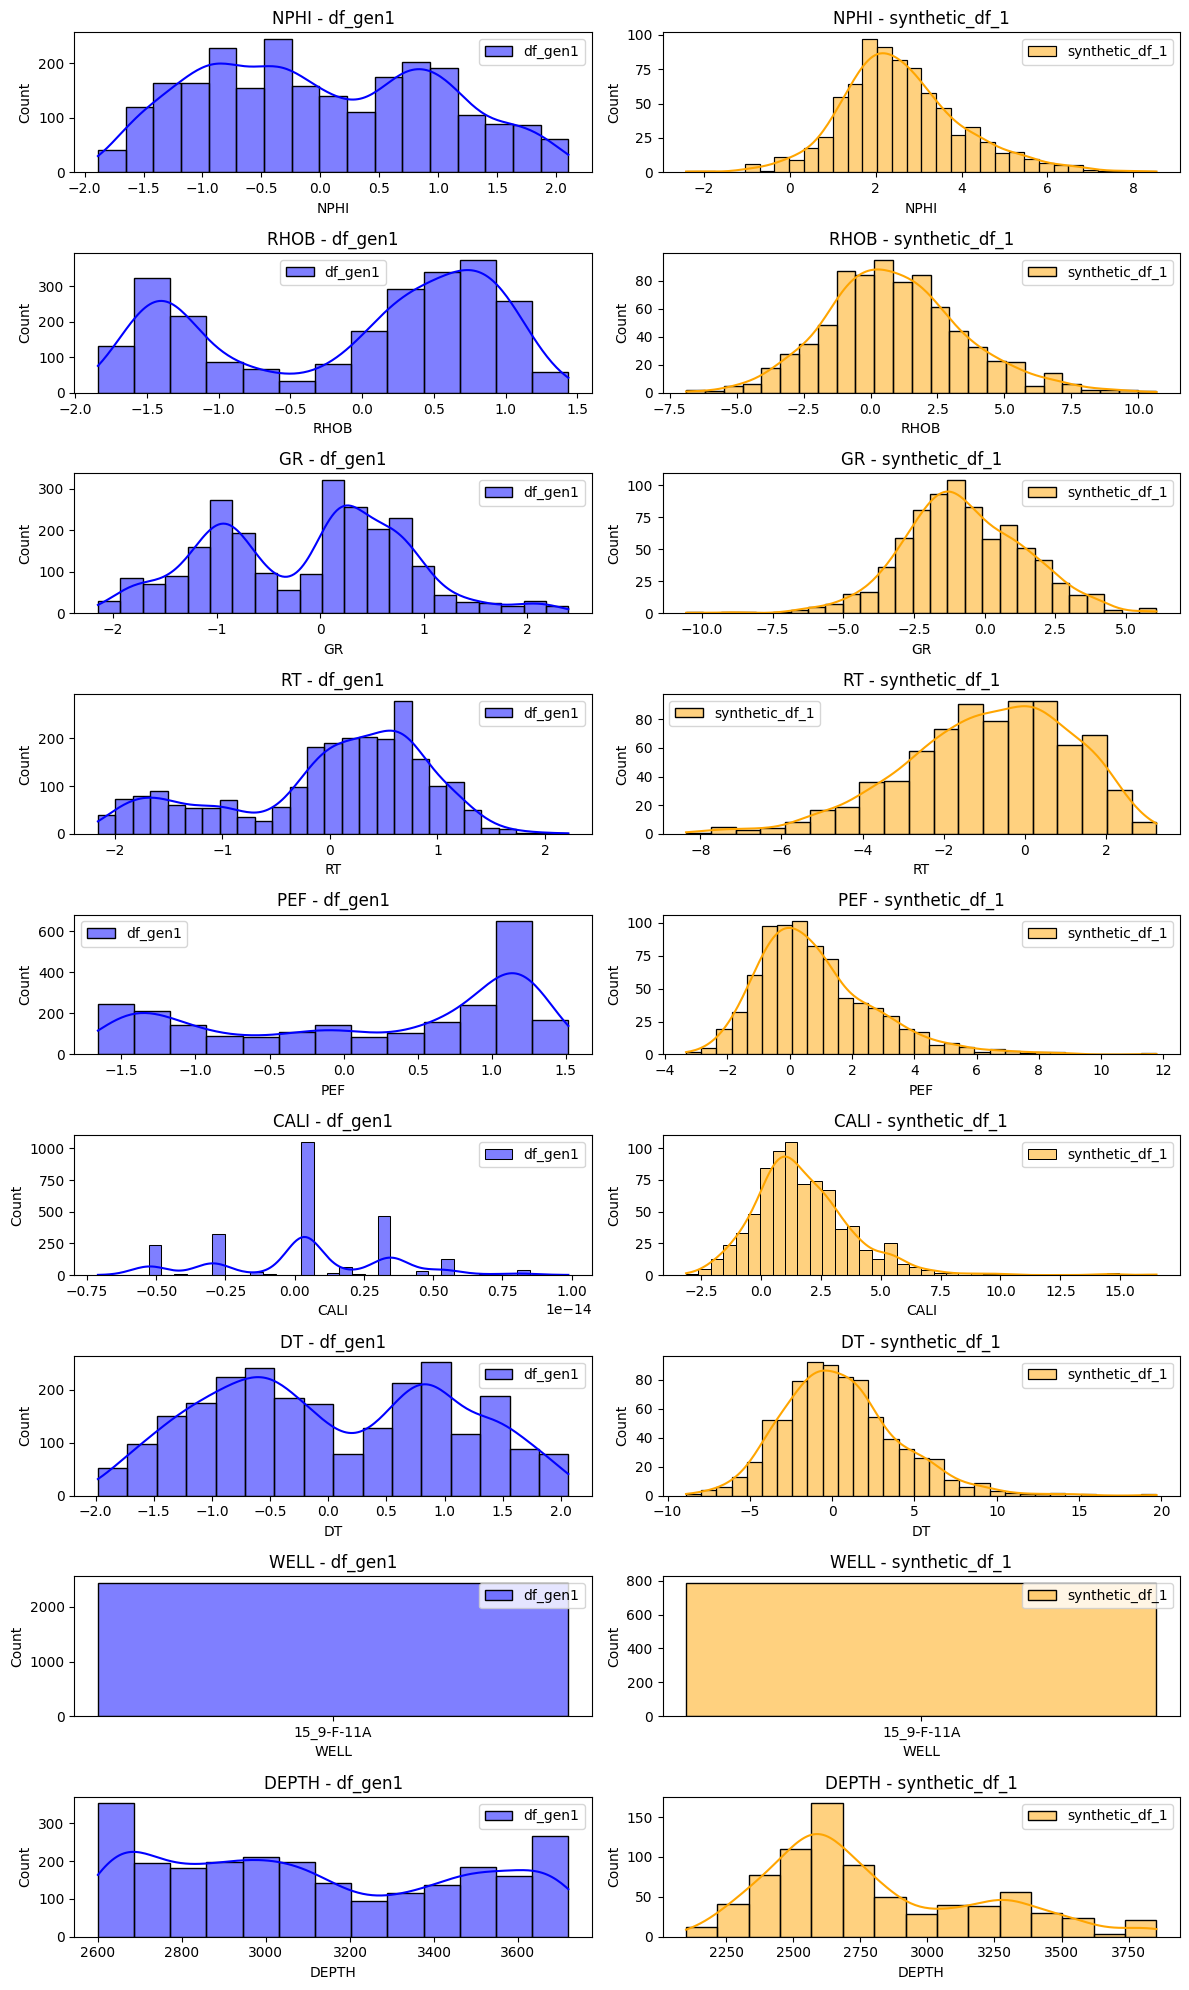

In [38]:
fig, axes = plt.subplots(nrows=len(df_gen1.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_1
for i, column in enumerate(df_gen1.columns):
    sns.histplot(df_gen1[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen1')
    axes[i, 0].set_title(f'{column} - df_gen1')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_1[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_1')
    axes[i, 1].set_title(f'{column} - synthetic_df_1')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

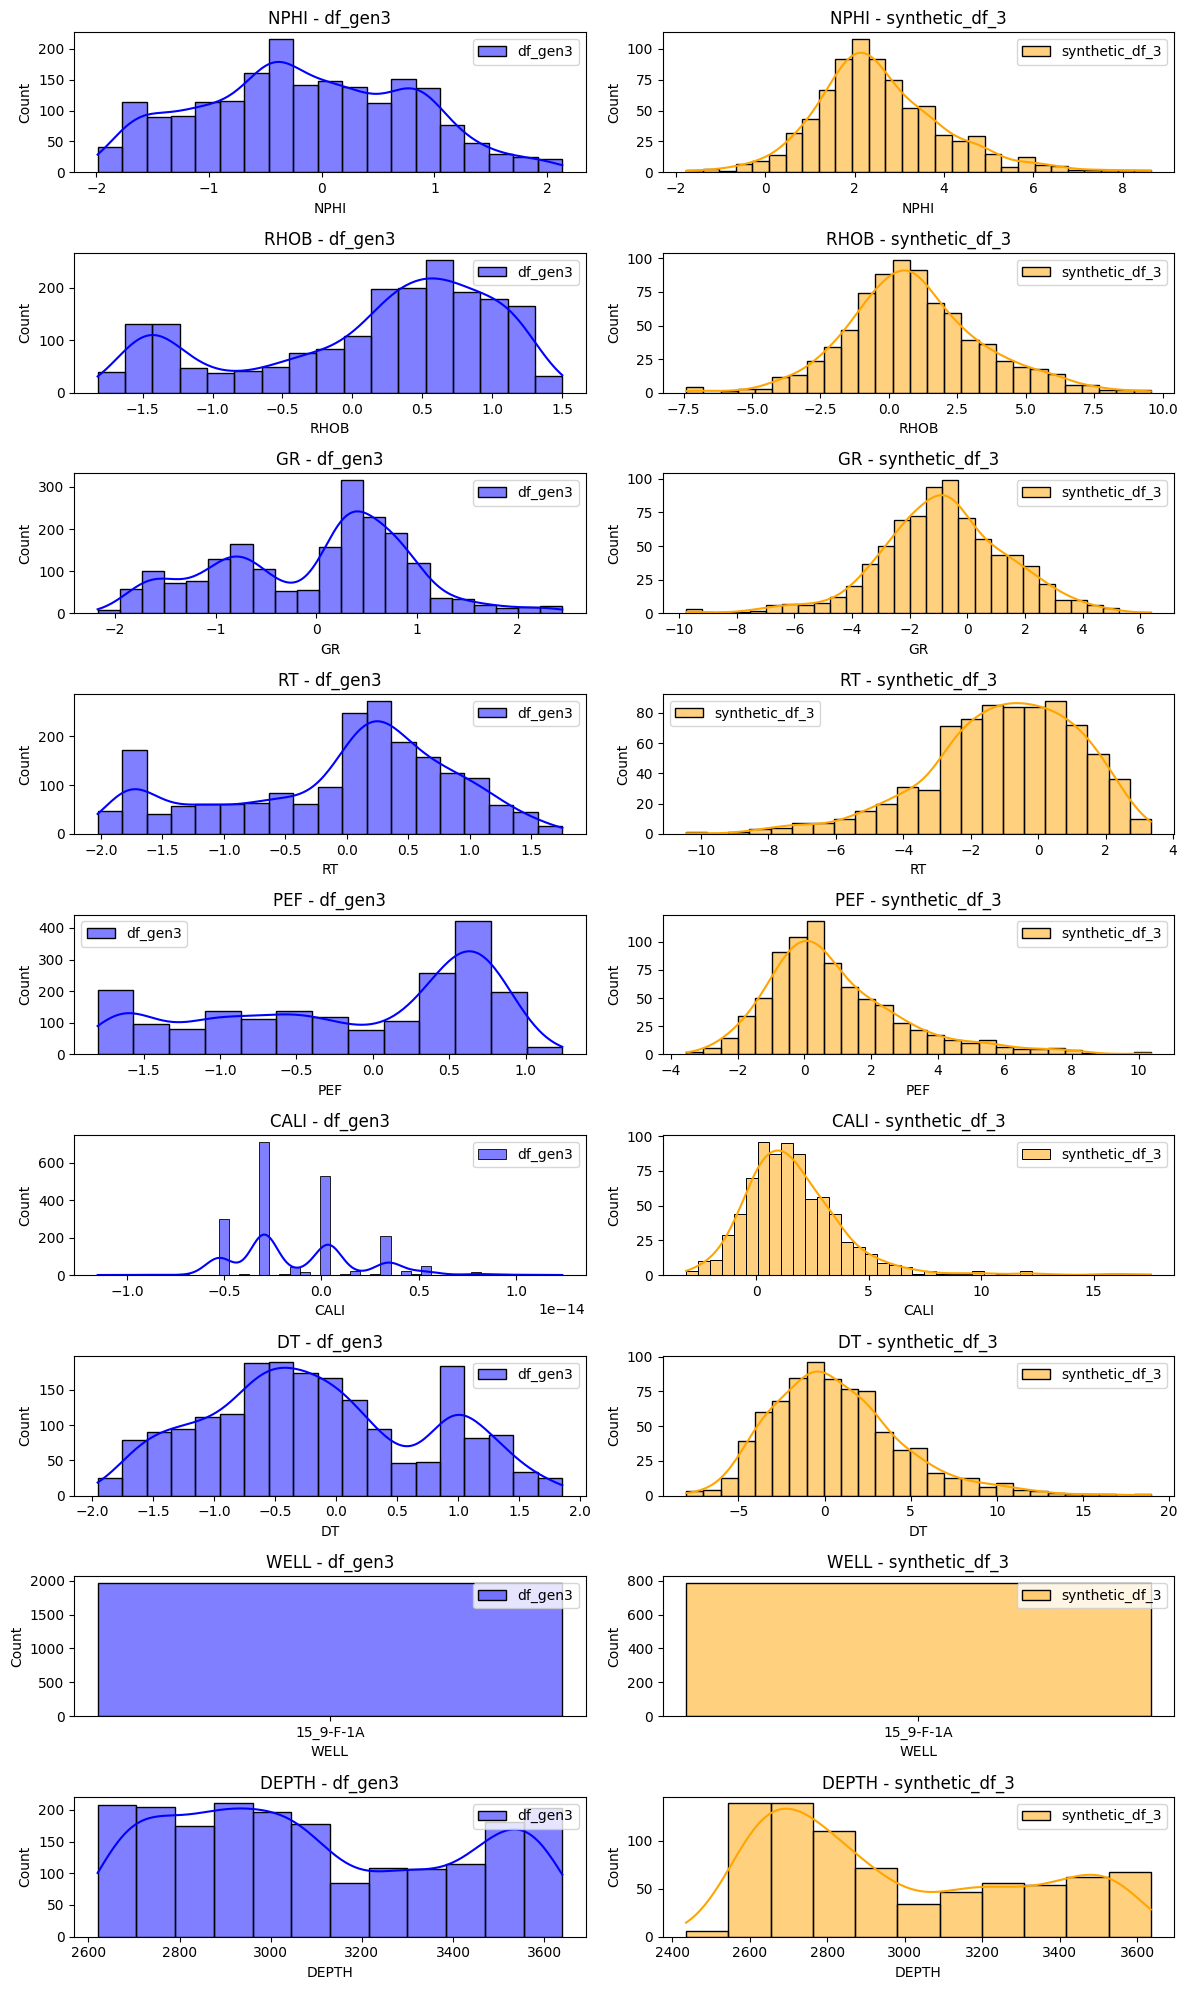

In [39]:
fig, axes = plt.subplots(nrows=len(df_gen3.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen3 and synthetic_df_3
for i, column in enumerate(df_gen3.columns):
    sns.histplot(df_gen3[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen3')
    axes[i, 0].set_title(f'{column} - df_gen3')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_3[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_3')
    axes[i, 1].set_title(f'{column} - synthetic_df_3')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

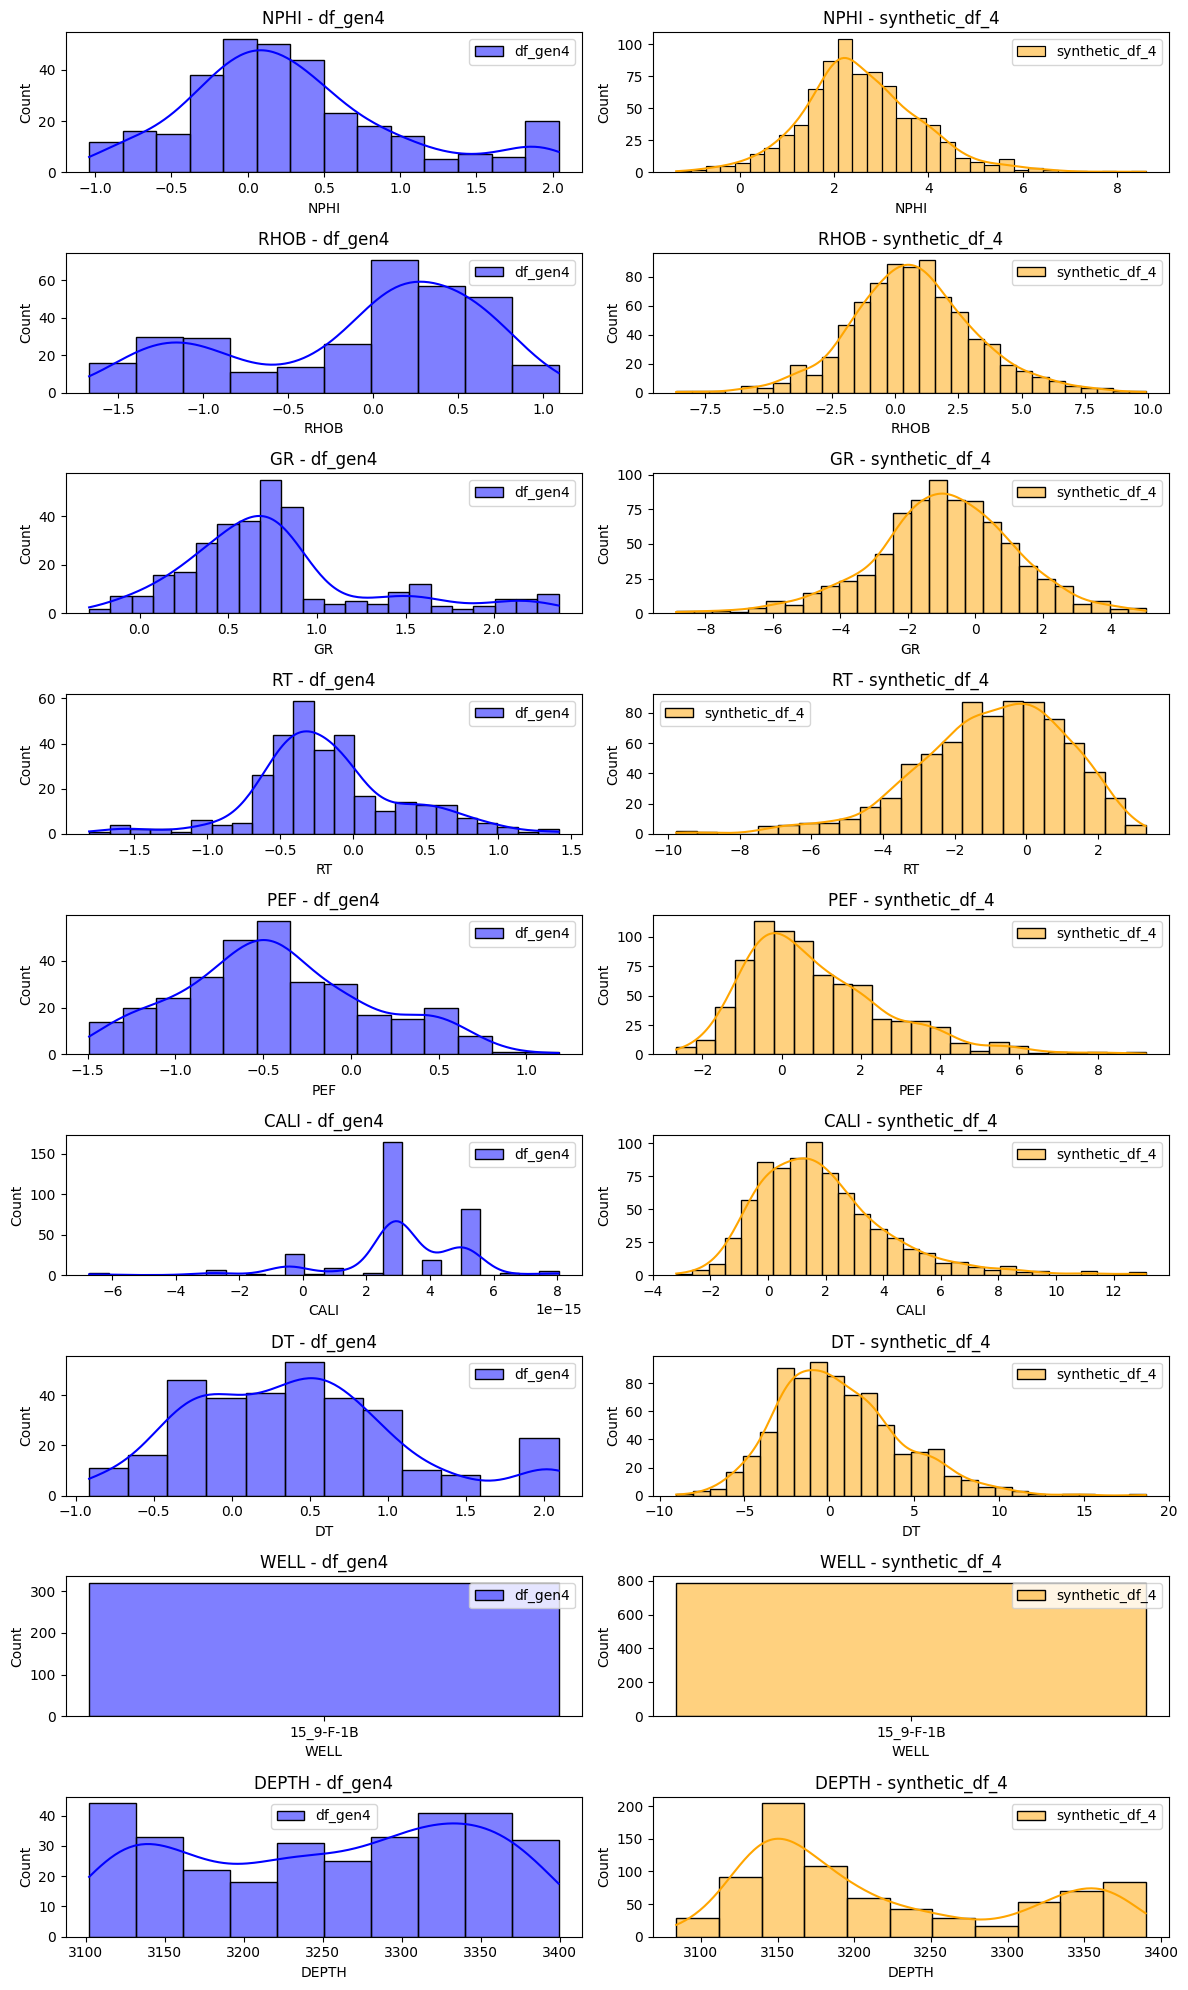

In [40]:
fig, axes = plt.subplots(nrows=len(df_gen4.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_4
for i, column in enumerate(df_gen4.columns):
    sns.histplot(df_gen4[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen4')
    axes[i, 0].set_title(f'{column} - df_gen4')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_4[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_4')
    axes[i, 1].set_title(f'{column} - synthetic_df_4')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [41]:
df_gen1 = pd.concat([df_gen1, synthetic_df_1])
df_gen1 = df_gen1.sort_values(by='DEPTH')

df_gen3 = pd.concat([df_gen1, synthetic_df_3])
df_gen3  = df_gen3.sort_values(by='DEPTH')

df_gen4 = pd.concat([df_gen1, synthetic_df_4])
df_gen4 = df_gen4.sort_values(by='DEPTH')


In [42]:
X_train_new = pd.concat([df_gen1, df_gen3, df_gen4])
y_train_new = X_train_new['DT']
X_train_new.drop(['DT', 'WELL', 'DEPTH'], axis = 1, inplace= True)

y_train_new = y_train_new.values.reshape(-1,1).astype('float32')
X_train_new = X_train_new.values.astype('float32')

### Decison Tree Regressor


In [43]:
# Decision Tree Regressor object
model_decision_tree = DecisionTreeRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the regressor to the training fold
    model_decision_tree.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = model_decision_tree.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_decision_tree = model_decision_tree.predict(X_val1)
print("R2 Log 1: {}".format(round(model_decision_tree.score(X_val1, y_val1), 4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_decision_tree))
print("RMSE Log 1: {}".format(round(rmse, 4)))

# Validation: Predict on well 3
y_pred3_decision_tree = model_decision_tree.predict(X_val3)
print("R2 Log 3: {}".format(round(model_decision_tree.score(X_val3, y_val3), 4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_decision_tree))
print("RMSE Log 3: {}".format(round(rmse, 4)))

# Validation: Predict on well 4
y_pred4_decision_tree = model_decision_tree.predict(X_val4)
print("R2 Log 4: {}".format(round(model_decision_tree.score(X_val4, y_val4), 4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_decision_tree))
print("RMSE Log 4: {}".format(round(rmse, 4)))


RMSE for Fold 1: 0.2514
RMSE for Fold 2: 0.2723
RMSE for Fold 3: 0.2688
RMSE for Fold 4: 0.2768
RMSE for Fold 5: 0.2675
Average RMSE: 0.2674
R2 Log 1: 0.9574
RMSE Log 1: 0.2194
R2 Log 3: 0.966
RMSE Log 3: 0.1714
R2 Log 4: 0.9199
RMSE Log 4: 0.2129


### Gradient Booster Regressor

In [44]:
# Gradient Booster object
model_grad_boost = GradientBoostingRegressor()

# Initialize KFold with number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the regressor to the training fold
    model_grad_boost.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = model_grad_boost.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_grad_boost = model_grad_boost.predict(X_val1)
print("R2 Log 1: {}".format(round(model_grad_boost.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_grad_boost))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3_grad_boost = model_grad_boost.predict(X_val3)
print("R2 Log 3: {}".format(round(model_grad_boost.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_grad_boost))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4_grad_boost = model_grad_boost.predict(X_val4)
print("R2 Log 4: {}".format(round(model_grad_boost.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_grad_boost))
print("RMSE Log 4: {}".format(round(rmse,4)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 1: 0.2008


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 2: 0.2121


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 3: 0.2201


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 4: 0.2201


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 5: 0.2130
Average RMSE: 0.2132
R2 Log 1: 0.9488
RMSE Log 1: 0.2406
R2 Log 3: 0.9468
RMSE Log 3: 0.2144
R2 Log 4: 0.883
RMSE Log 4: 0.2573


### Neural Network

In [45]:
# Define the neural network model
def neural_network_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer
    ])
    return model

# Initialize and compile the neural network model
model_nn = neural_network_model(X_train_new.shape[1:])
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Initialize KFold with number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the neural network model to the training fold
    history_nn = model_nn.fit(X_train_fold, y_train_fold, epochs=16, batch_size=1024, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Predict on the validation fold
    y_pred_fold = model_nn.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_nn = model_nn.predict(X_val1)
rmse_nn1 = np.sqrt(mean_squared_error(y_val1, y_pred1_nn))
print("RMSE Neural Network Log 1: {}".format(round(rmse_nn1, 4)))

# Validation: Predict on well 3
y_pred3_nn = model_nn.predict(X_val3)
rmse_nn3 = np.sqrt(mean_squared_error(y_val3, y_pred3_nn))
print("RMSE Neural Network Log 3: {}".format(round(rmse_nn3, 4)))

# Validation: Predict on well 4
y_pred4_nn = model_nn.predict(X_val4)
rmse_nn4 = np.sqrt(mean_squared_error(y_val4, y_pred4_nn))
print("RMSE Neural Network Log 4: {}".format(round(rmse_nn4, 4)))


30/30 [==============================] - 0s 2ms/step
RMSE for Fold 1: 0.2090
30/30 [==============================] - 0s 1ms/step
RMSE for Fold 2: 0.2108
30/30 [==============================] - 0s 2ms/step
RMSE for Fold 3: 0.2180
30/30 [==============================] - 0s 1ms/step
RMSE for Fold 4: 0.2061
30/30 [==============================] - 0s 1ms/step
RMSE for Fold 5: 0.2082
Average RMSE: 0.2104
85/85 [==============================] - 0s 2ms/step
RMSE Neural Network Log 1: 0.27239999175071716
69/69 [==============================] - 0s 1ms/step
RMSE Neural Network Log 3: 0.21330000460147858
12/12 [==============================] - 0s 2ms/step
RMSE Neural Network Log 4: 0.2207999974489212


### LSTM

In [46]:
# Preparing data for LSTM
time_steps = 10

def prep_for_lstm(X_in, y_in, time_steps = 10):
    X_lstm = []
    y_lstm = []
    for i in range(len(X_in) - time_steps):
        X_lstm.append(X_in[i:i+time_steps])
        y_lstm.append(y_in[i+time_steps])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    return X_lstm, y_lstm

X_train_lstm, y_train_lstm = prep_for_lstm(X_train_new, y_train_new, time_steps = time_steps)
X_val1_lstm, y_val1_lstm = prep_for_lstm(X_val1, y_val1, time_steps = time_steps)
X_val3_lstm, y_val3_lstm = prep_for_lstm(X_val3, y_val3, time_steps = time_steps)
X_val4_lstm, y_val4_lstm = prep_for_lstm(X_val4, y_val4, time_steps = time_steps)


In [47]:
y_train_lstm.shape

(11245, 1)

In [48]:
# Define bidirectional LSTM model with three layers
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(units=64)))
model_lstm.add(Dense(units=1))  # Output layer
model_lstm.compile(optimizer=Adam(), loss='mean_squared_error')

# Initialize KFold with number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train_lstm)):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[val_index]
    y_train_fold, y_val_fold = y_train_lstm[train_index], y_train_lstm[val_index]


    # Fit the bidirectional LSTM model to the training fold
    history = model_lstm.fit(X_train_fold, y_train_fold, epochs=16, batch_size=1024, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Predict on the validation fold
    y_pred_fold = model_lstm.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_lstm = model_lstm.predict(X_val1_lstm)
rmse_lstm1 = np.sqrt(mean_squared_error(y_val1_lstm, y_pred1_lstm))
print("RMSE LSTM Log 1: {}".format(round(rmse_lstm1, 4)))

# Validation: Predict on well 3
y_pred3_lstm = model_lstm.predict(X_val3_lstm)
rmse_lstm3 = np.sqrt(mean_squared_error(y_val3_lstm, y_pred3_lstm))
print("RMSE LSTM Log 3: {}".format(round(rmse_lstm3, 4)))

# Validation: Predict on well 4
y_pred4_lstm = model_lstm.predict(X_val4_lstm)
rmse_lstm4 = np.sqrt(mean_squared_error(y_val4_lstm, y_pred4_lstm))
print("RMSE LSTM Log 4: {}".format(round(rmse_lstm4, 4)))


71/71 [==============================] - 2s 5ms/step
RMSE for Fold 1: 1.9527
71/71 [==============================] - 0s 6ms/step
RMSE for Fold 2: 1.8867
71/71 [==============================] - 0s 4ms/step
RMSE for Fold 3: 1.8848
71/71 [==============================] - 0s 5ms/step
RMSE for Fold 4: 1.6320
71/71 [==============================] - 0s 5ms/step
RMSE for Fold 5: 1.5167
Average RMSE: 1.7746
85/85 [==============================] - 1s 6ms/step
RMSE LSTM Log 1: 0.475600004196167
68/68 [==============================] - 0s 6ms/step
RMSE LSTM Log 3: 0.7554000020027161
12/12 [==============================] - 0s 8ms/step
RMSE LSTM Log 4: 0.5212000012397766


### Formatting back the predictions

In [49]:
# Make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform  y_val, y_pred
y_val1 = scaler.inverse_transform(y_val1.reshape(-1,1))
y_val3 = scaler.inverse_transform(y_val3.reshape(-1,1))
y_val4 = scaler.inverse_transform(y_val4.reshape(-1,1))


# Define a list to hold all predictions
all_predictions = [y_pred1_grad_boost, y_pred3_grad_boost, y_pred4_grad_boost,
                   y_pred1_nn, y_pred3_nn, y_pred4_nn,
                   y_pred1_lstm, y_pred3_lstm, y_pred4_lstm,
                   y_pred1_decision_tree, y_pred3_decision_tree, y_pred4_decision_tree
                   ]

# Inverse transform all predictions
all_predictions_inverse = [scaler.inverse_transform(pred.reshape(-1, 1)) for pred in all_predictions]

# Split the transformed predictions back into separate variables
(
    y_pred1_grad_boost_inv,  y_pred3_grad_boost_inv, y_pred4_grad_boost_inv,
    y_pred1_nn_inv, y_pred3_nn_inv, y_pred4_nn_inv,
    y_pred1_lstm_inv, y_pred3_lstm_inv, y_pred4_lstm_inv,
    y_pred1_decision_tree_inv, y_pred3_decision_tree_inv, y_pred4_decision_tree_inv
) = all_predictions_inverse

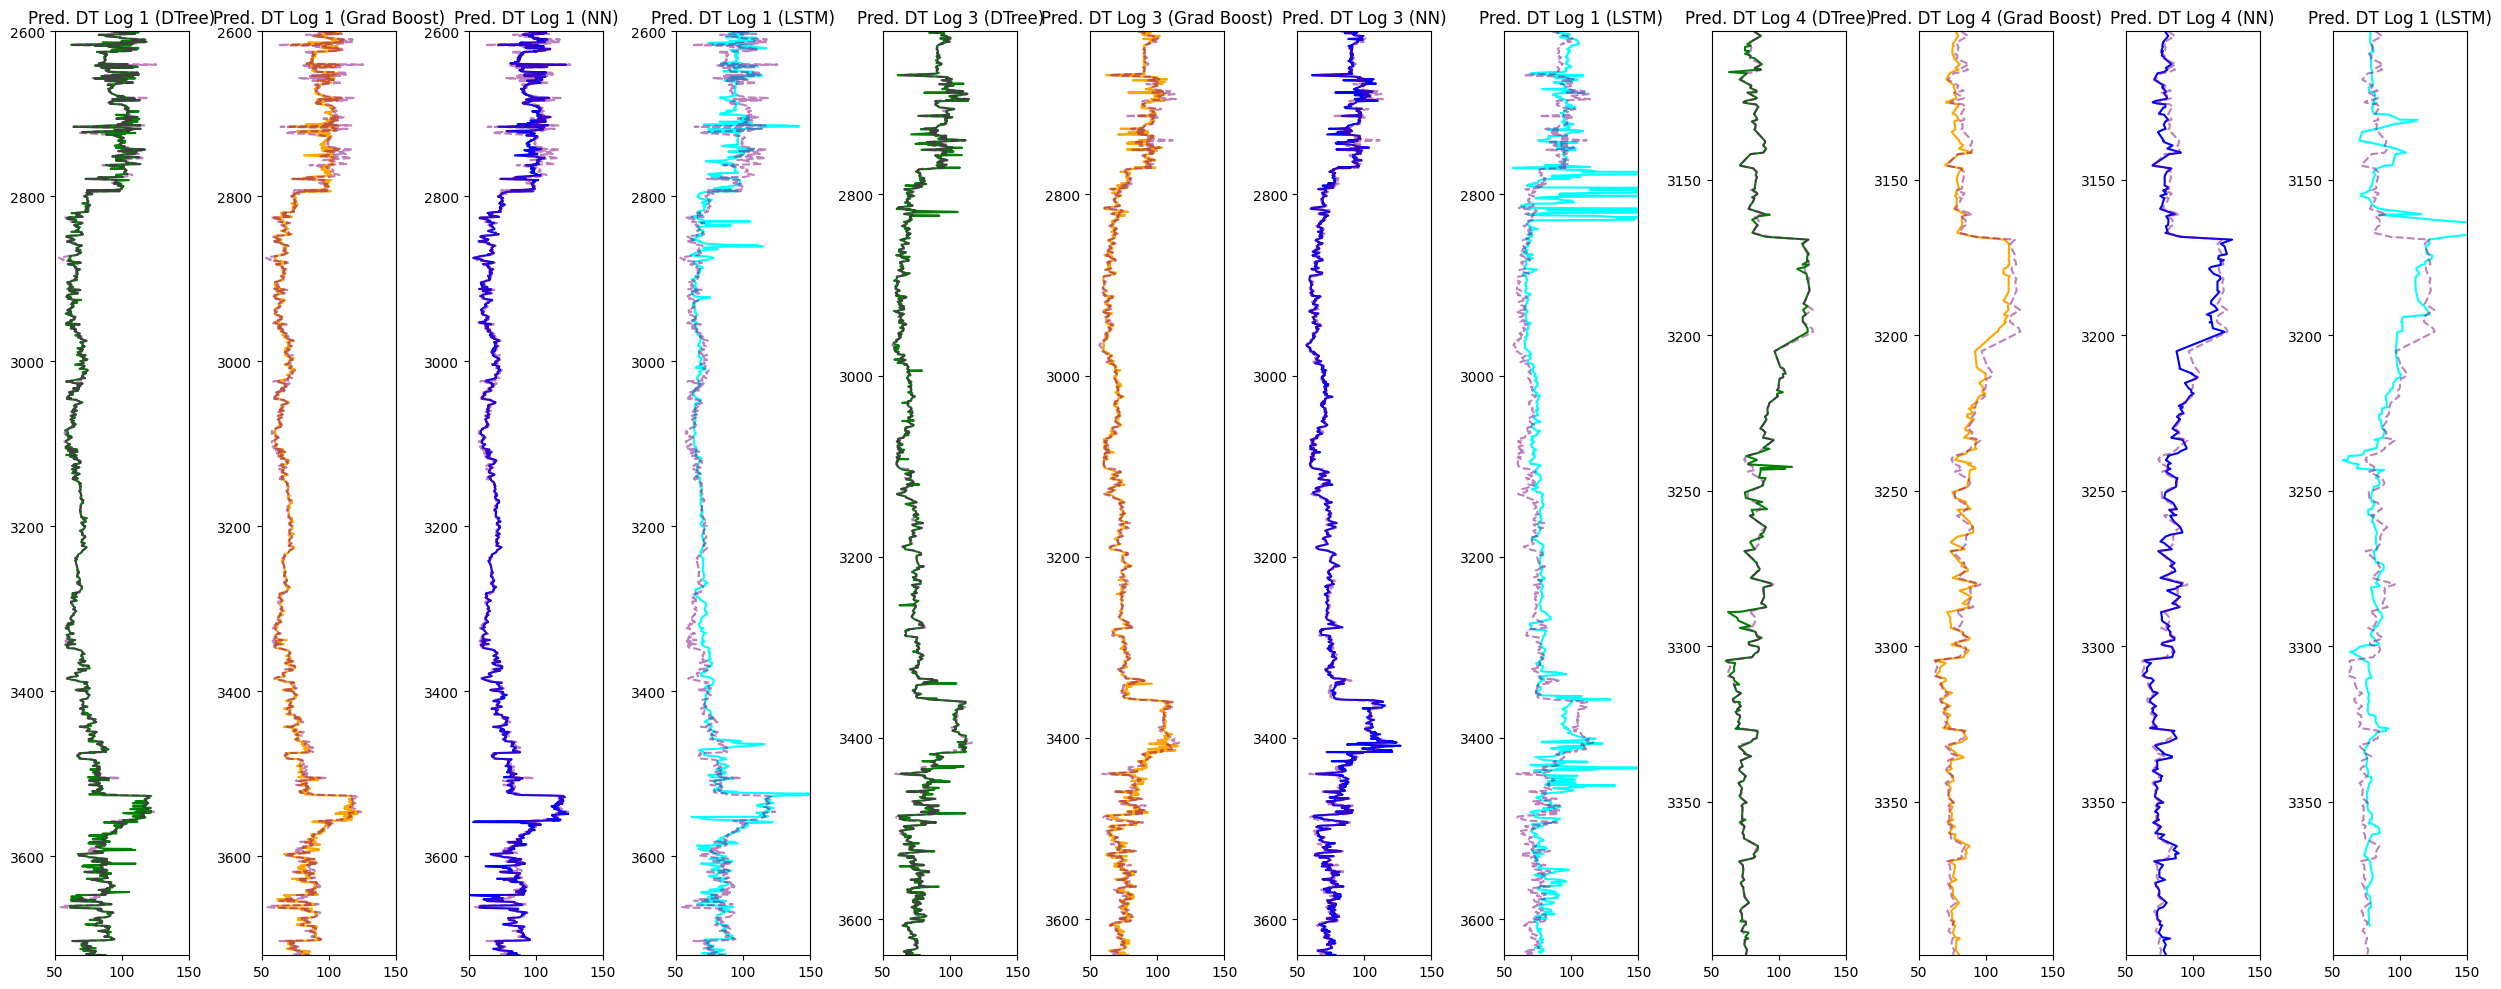

In [50]:
x_plott = [y_pred1_decision_tree_inv, y_pred1_grad_boost_inv, y_pred1_nn_inv,  y_pred1_lstm_inv,
           y_pred3_decision_tree_inv, y_pred3_grad_boost_inv, y_pred3_nn_inv,  y_pred3_lstm_inv,
           y_pred4_decision_tree_inv, y_pred4_grad_boost_inv, y_pred4_nn_inv,  y_pred4_lstm_inv]

x_real_plott = [
    y_val1,
    y_val3,
    y_val4
]

x_real_plott_lstm = [
    y_val1_lstm,
    y_val3_lstm,
    y_val4_lstm
]

y_plott =  [train_preserve[train_preserve['WELL'] == '15_9-F-11A']['DEPTH'],
            train_preserve[train_preserve['WELL'] == '15_9-F-1A']['DEPTH'],
            train_preserve[train_preserve['WELL'] == '15_9-F-1B']['DEPTH']]

#  [log1['DEPTH'],
#            log3['DEPTH'],
#            log4['DEPTH']]

color_preds = ['green', 'orange', 'blue', 'cyan'] * 3
title_preds = ['Pred. DT Log 1 (DTree)', 'Pred. DT Log 1 (Grad Boost)', 'Pred. DT Log 1 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 3 (DTree)', 'Pred. DT Log 3 (Grad Boost)', 'Pred. DT Log 3 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 4 (DTree)', 'Pred. DT Log 4 (Grad Boost)', 'Pred. DT Log 4 (NN)',  'Pred. DT Log 1 (LSTM)',]

fig, ax = plt.subplots(nrows=1, ncols=12, figsize=(25, 10))

for i, (x_pred, title) in enumerate(zip(x_plott, title_preds)):
    # Reshape y[i] to match the shape of x_pred
    y_i_reshaped = y_plott[i//4]
    ax[i].plot(x_pred, y_i_reshaped[:len(x_pred)], color=color_preds[i])
    ax[i].plot(x_real_plott[i//4], y_i_reshaped, color='purple', linestyle='dashed', alpha = 0.5) #if i%4 != 0 else x_real_plott_lstm[i//4]
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(max(y_i_reshaped), min(y_i_reshaped))  # Ensure correct order of y-axis
    ax[i].set_title(title)

plt.tight_layout()
plt.show()


In [51]:
# Define the test data
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column
  test = test.drop(['WELL'], axis=1)

  # Define X_test (feature)
  X_test_ = test[feature_names].values

  # Define depth
  depth_ = test['DEPTH'].values

  X_test.append(X_test_)
  depths.append(depth_)

# For each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [52]:
X_test2

array([[ 0.075,  2.605,  9.348,  8.331,  7.451,  8.547],
       [ 0.077,  2.602,  9.362,  8.289,  7.464,  8.547],
       [ 0.078,  2.599,  9.545,  8.247,  7.405,  8.547],
       ...,
       [ 0.103,  2.592, 32.217,  4.232,  4.729,  8.734],
       [ 0.108,  2.583, 29.841,  4.233,  4.705,  8.75 ],
       [ 0.114,  2.571, 31.423,  4.225,  4.617,  8.76 ]])

In [53]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

X_test2_lstm, _ = prep_for_lstm(X_test2, X_test2, time_steps = time_steps)
X_test5_lstm, _ = prep_for_lstm(X_test5, X_test5, time_steps = time_steps)


# Predictions for log 2 using all models
y_pred2_grad_boost = model_grad_boost.predict(X_test2)
y_pred2_decision_tree = model_decision_tree.predict(X_test2)
y_pred2_nn = model_nn.predict(X_test2)
y_pred2_lstm = model_lstm.predict(X_test2_lstm)
#y_pred2_transformer = model_transformer.predict(X_test2)

# Predictions for log 5 using all models
y_pred5_grad_boost = model_grad_boost.predict(X_test5)
y_pred5_decision_tree = model_decision_tree.predict(X_test5)
y_pred5_nn = model_nn.predict(X_test5)
y_pred5_lstm = model_lstm.predict(X_test5_lstm)
#y_pred5_transformer = model_transformer.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform y_pred for log 2
y_pred2_grad_boost = scaler.inverse_transform(y_pred2_grad_boost.reshape(-1,1))
y_pred2_decision_tree = scaler.inverse_transform(y_pred2_decision_tree.reshape(-1,1))
y_pred2_nn = scaler.inverse_transform(y_pred2_nn.reshape(-1,1))
y_pred2_lstm = scaler.inverse_transform(y_pred2_lstm.reshape(-1,1))
#y_pred2_transformer = scaler.inverse_transform(y_pred2_transformer.reshape(-1,1))

# Inverse transform y_pred for log 5
y_pred5_grad_boost = scaler.inverse_transform(y_pred5_grad_boost.reshape(-1,1))
y_pred5_decision_tree = scaler.inverse_transform(y_pred5_decision_tree.reshape(-1,1))
y_pred5_nn = scaler.inverse_transform(y_pred5_nn.reshape(-1,1))
y_pred5_lstm = scaler.inverse_transform(y_pred5_lstm.reshape(-1,1))
#y_pred5_transformer = scaler.inverse_transform(y_pred5_transformer.reshape(-1,1))


297/297 [==============================] - 1s 5ms/step


In [54]:
def pad_predicted_values(predicted_values, target_column, window_size=10):
    """
    Pad the predicted values using a moving average to fill in the gaps.

    Parameters:
        predicted_values (np.ndarray): The predicted values to pad.
        target_column (pd.Series): The target column used to calculate moving average.
        window_size (int): The size of the moving average window.

    Returns:
        np.ndarray: The padded predicted values.
    """
    # Calculate the number of values to pad
    pad_length = len(target_column) - len(predicted_values)

    # Pad the predicted values with NaNs to match the length of target_column
    padding = np.full((pad_length, 1), np.nan)

    padded_values = np.concatenate((padding, predicted_values))

    for i in range(len(padded_values)-1, -1, -1):
        if np.isnan(padded_values[i][0]):
            padded_values[i][0] = np.mean(padded_values[i+1:i+1+window_size])



    return padded_values


In [55]:
y_pred2_lstm

array([[67.06276 ],
       [67.143234],
       [67.34545 ],
       ...,
       [77.24178 ],
       [76.93989 ],
       [76.60784 ]], dtype=float32)

In [56]:
pad_predicted_values(y_pred2_lstm, y_pred2_nn)

array([[67.54379312],
       [67.50737868],
       [67.49265801],
       ...,
       [77.24178314],
       [76.939888  ],
       [76.60784149]])

In [57]:
# Add predictions for log 2 to the dataframes
log2['DT_grad_boost'] = y_pred2_grad_boost
log2['DT_Tree'] = y_pred2_decision_tree
log2['DT_nn'] = y_pred2_nn
log2['DT_lstm'] = pad_predicted_values(y_pred2_lstm, log2['DT_Tree'])


# Add predictions for log 5 to the dataframes
log5['DT_grad_boost'] = y_pred5_grad_boost
log5['DT_Tree'] = y_pred5_decision_tree
log5['DT_nn'] = y_pred5_nn
log5['DT_lstm'] = pad_predicted_values(y_pred5_lstm, log5['DT_Tree'])
#log5['DT_transformer'] = y_pred5_transformer


<ipython-input-57-b0e2fc4a4f3b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_grad_boost'] = y_pred5_grad_boost
<ipython-input-57-b0e2fc4a4f3b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_Tree'] = y_pred5_decision_tree
<ipython-input-57-b0e2fc4a4f3b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

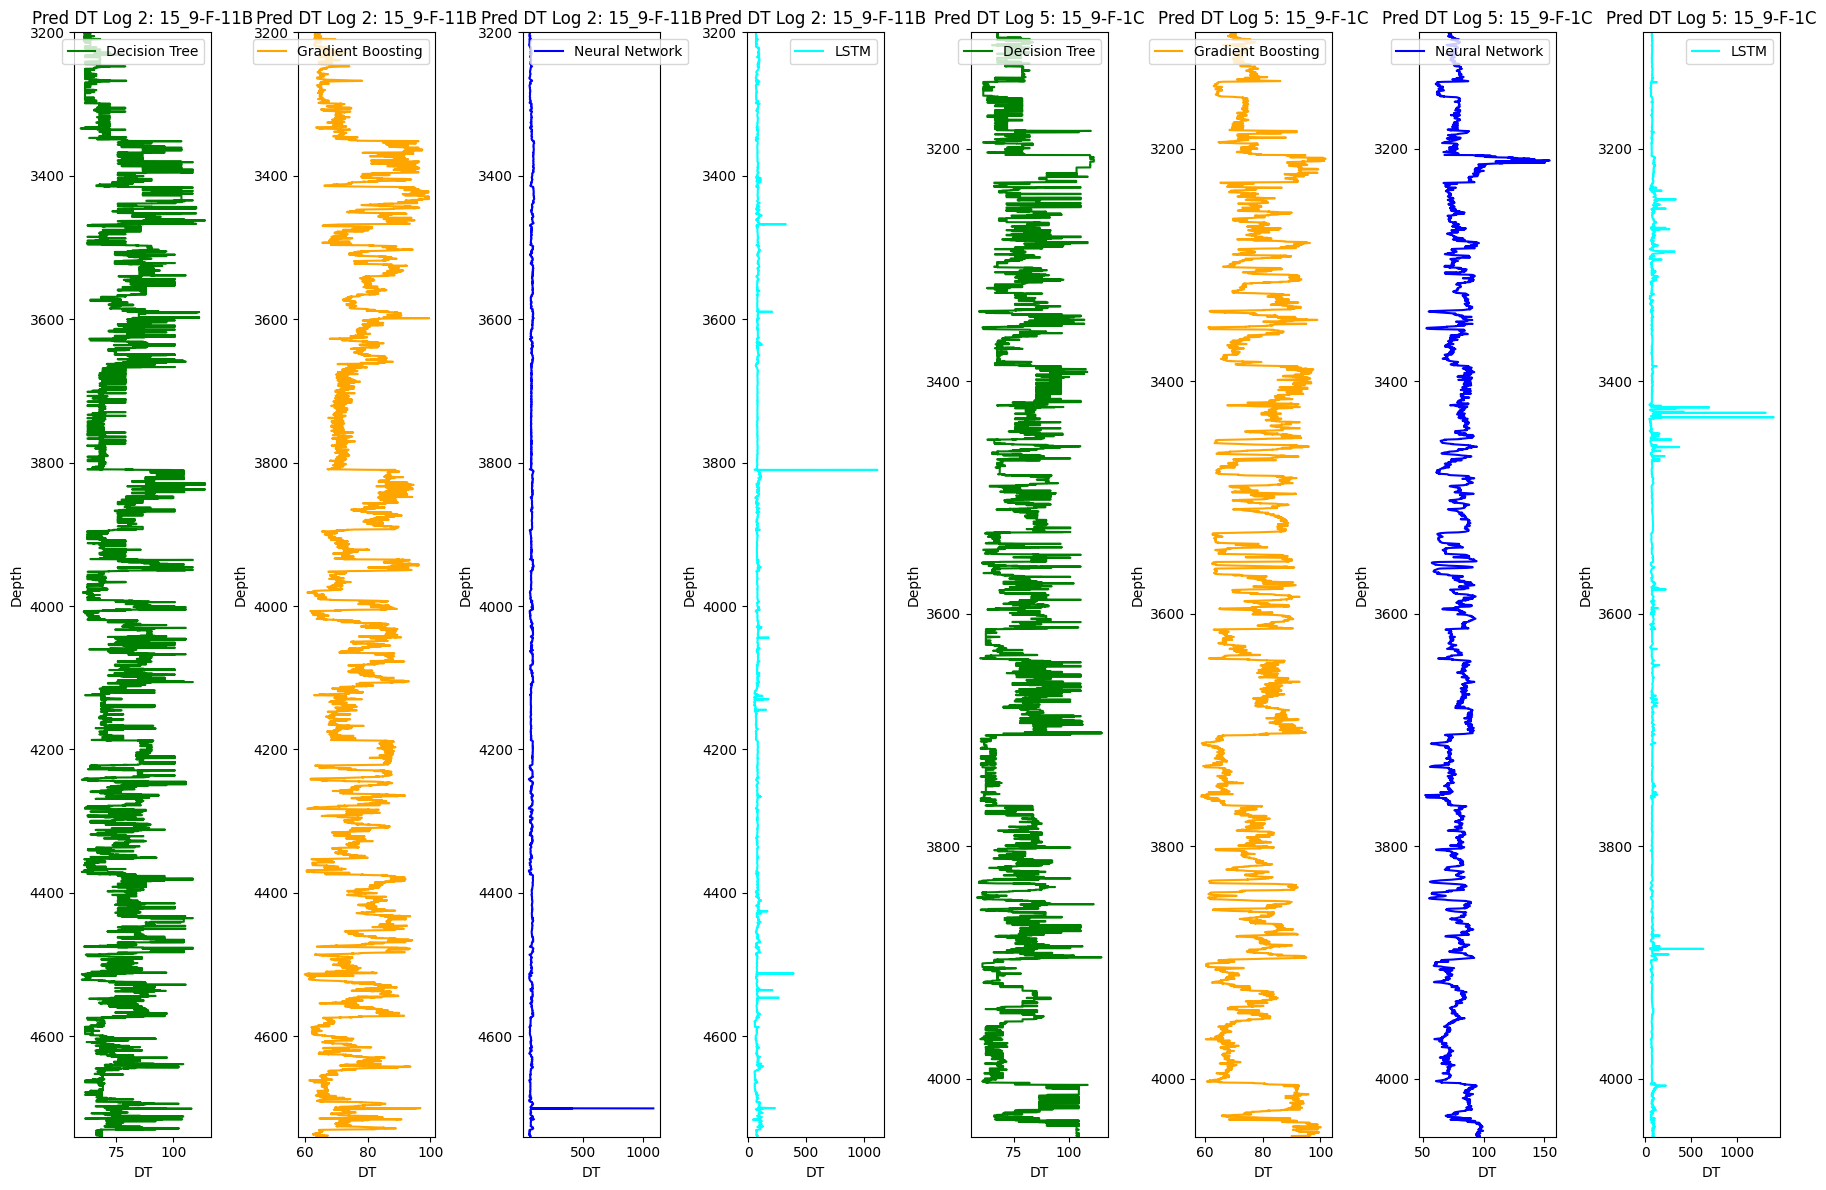

In [58]:
plt.figure(figsize=(18, 12))

# Plot predictions for log 2

plt.subplot(1, 8, 1)
plt.plot(y_pred2_decision_tree, depth2, color='green', label='Decision Tree')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 2)
plt.plot(y_pred2_grad_boost, depth2, color='orange', label='Gradient Boosting')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 3)
plt.plot(y_pred2_nn, depth2, color='blue', label='Neural Network')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 4)
plt.plot(pad_predicted_values(y_pred2_lstm, depth2), depth2, color='cyan', label='LSTM')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

# For log 5

plt.subplot(1, 8, 5)
plt.plot(y_pred5_decision_tree, depth5, color='green', label='Decision Tree')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 6)
plt.plot(y_pred5_grad_boost, depth5, color='orange', label='Gradient Boosting')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 7)
plt.plot(y_pred5_nn, depth5, color='blue', label='Neural Network')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 8)
plt.plot(pad_predicted_values(y_pred5_lstm, depth5), depth5, color='cyan', label='LSTM')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.tight_layout()
plt.show()


In [59]:
def makeplotpred(df, color_list, suptitle_str="Pass a suptitle"):
    # Column selection from df
    col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT_Tree', 'DT_grad_boost', 'DT_nn', 'DT_lstm']
    # Plotting titles
    title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT Decsion Tree', 'Predicted DT GB', 'Predicted DT NN', 'Predicted DT LSTM']

    # Create the subplots; ncols equals the number of logs
    fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(20,15))
    fig.suptitle(suptitle_str, size=20, y=1.05)

    # Looping each log to display in the subplots
    for i in range(len(col_names)):
        if i == 3:
            # for resistivity, semilog plot
            ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=color_list[i])

        else:
            # for non-resistivity, normal plot
            ax[i].plot(df[col_names[i]], df['DEPTH'], color=color_list[i])

        ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
        ax[i].set_title(title[i], pad=15)
        ax[i].grid(True)
        ax[i].legend()

    ax[2].set_xlim(0, 200)
    plt.tight_layout()
    plt.show()

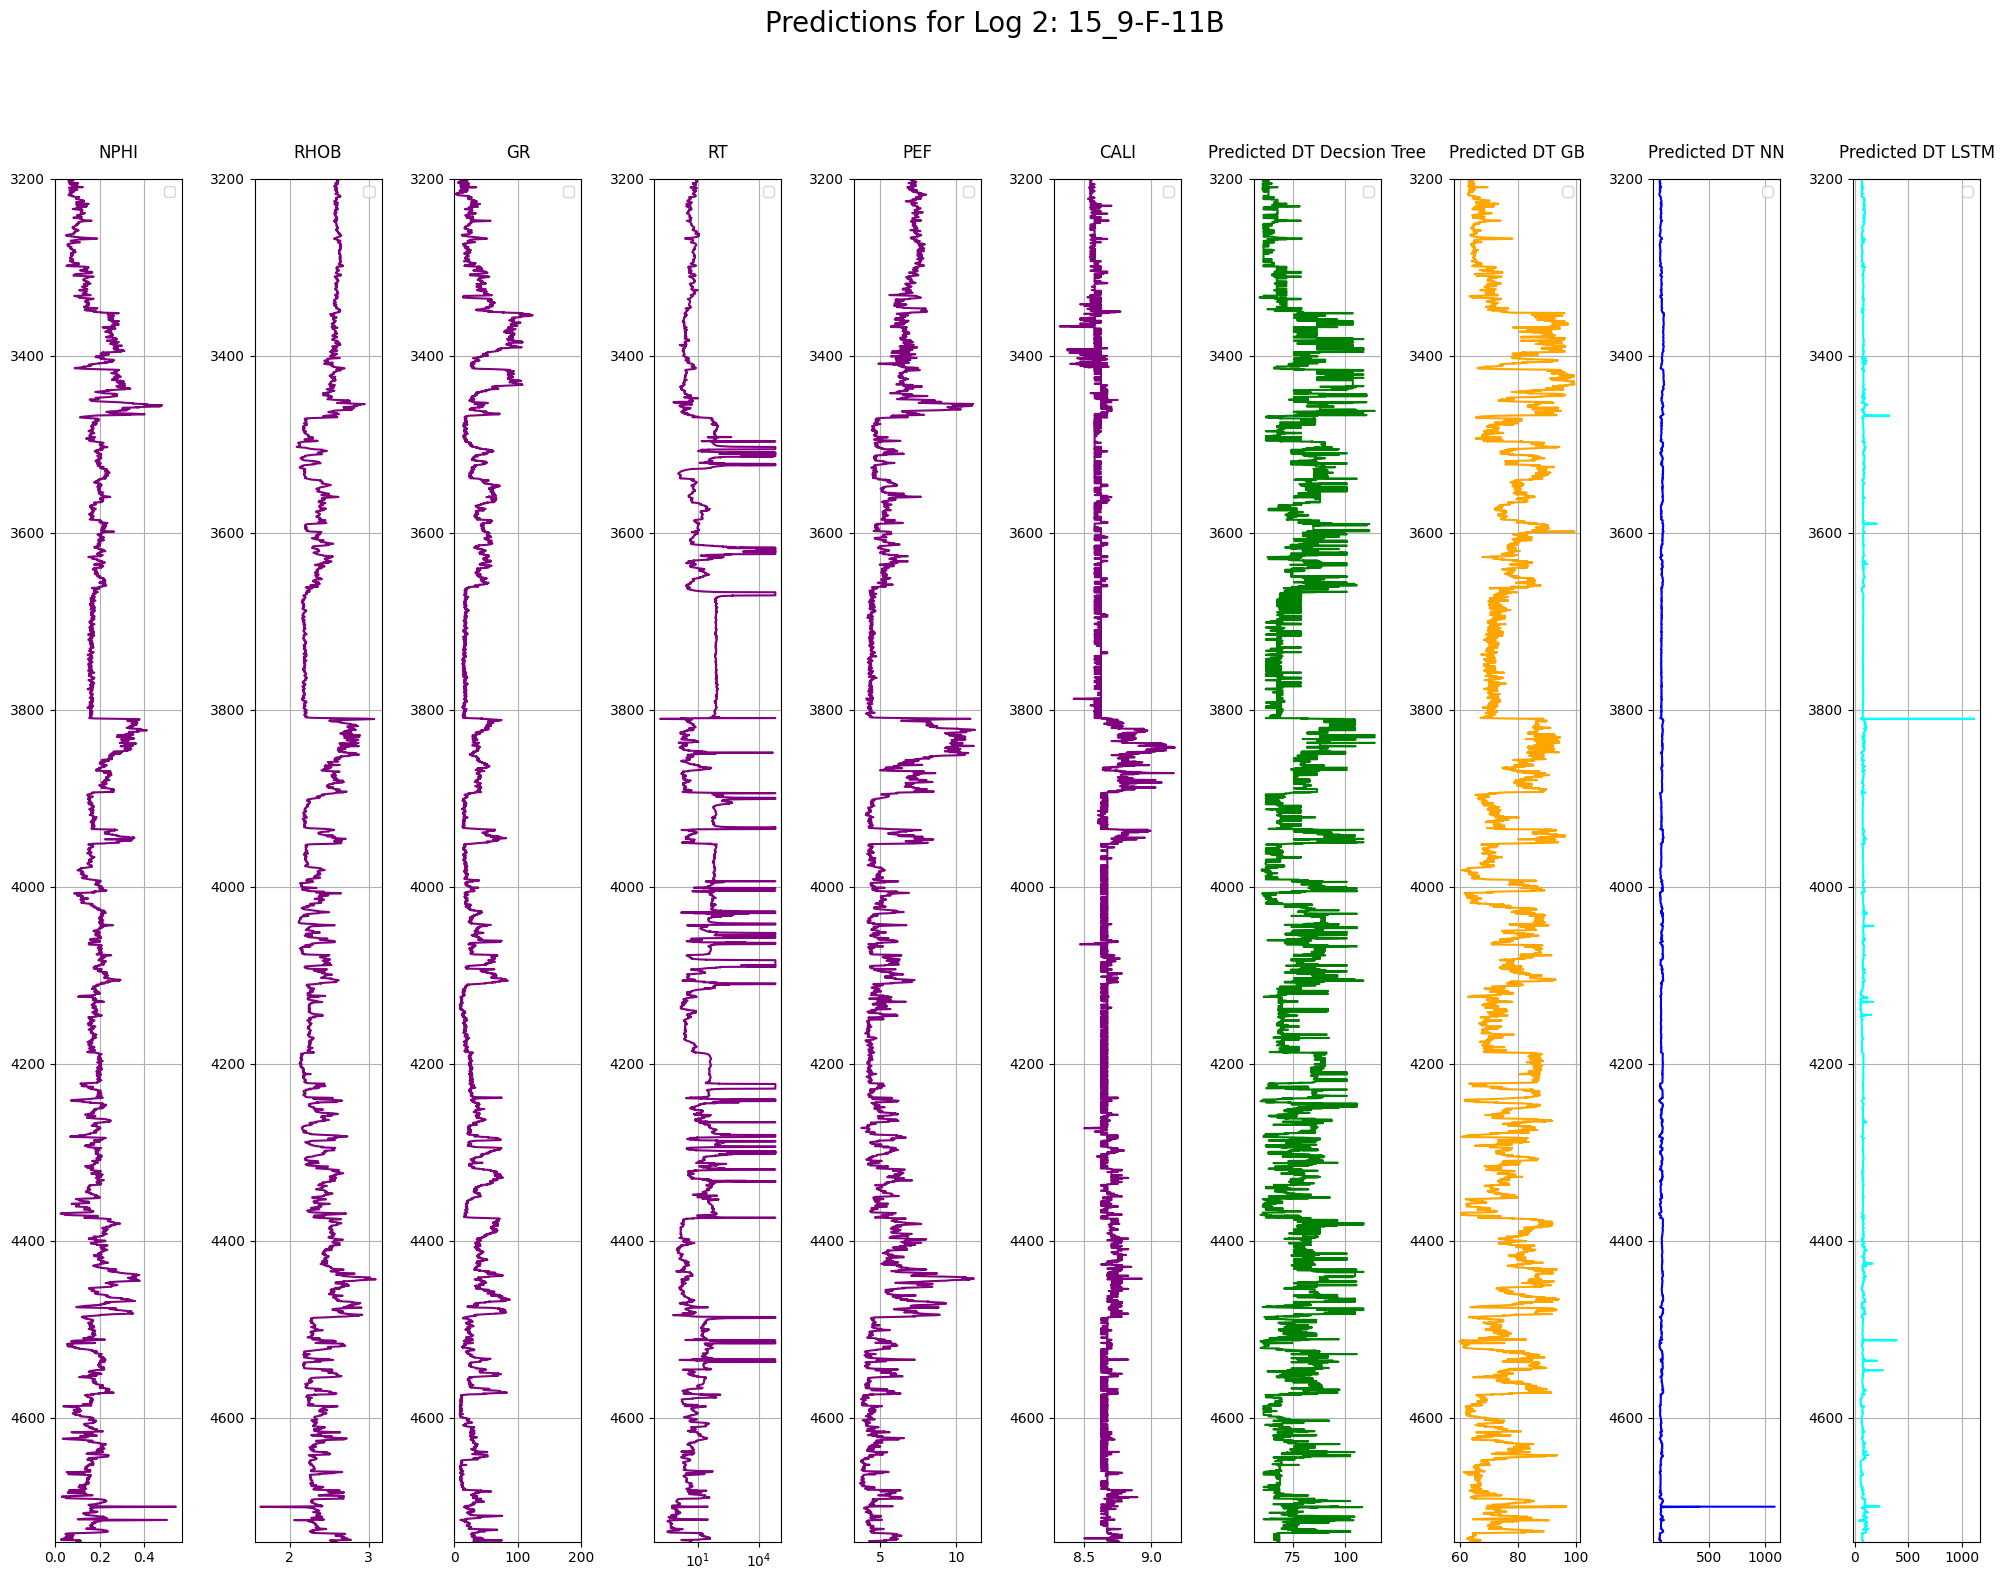

In [60]:
# Assuming `depth` is the depth information shared among all logs
makeplotpred(log2,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'cyan'],
             suptitle_str="Predictions for Log 2: 15_9-F-11B")

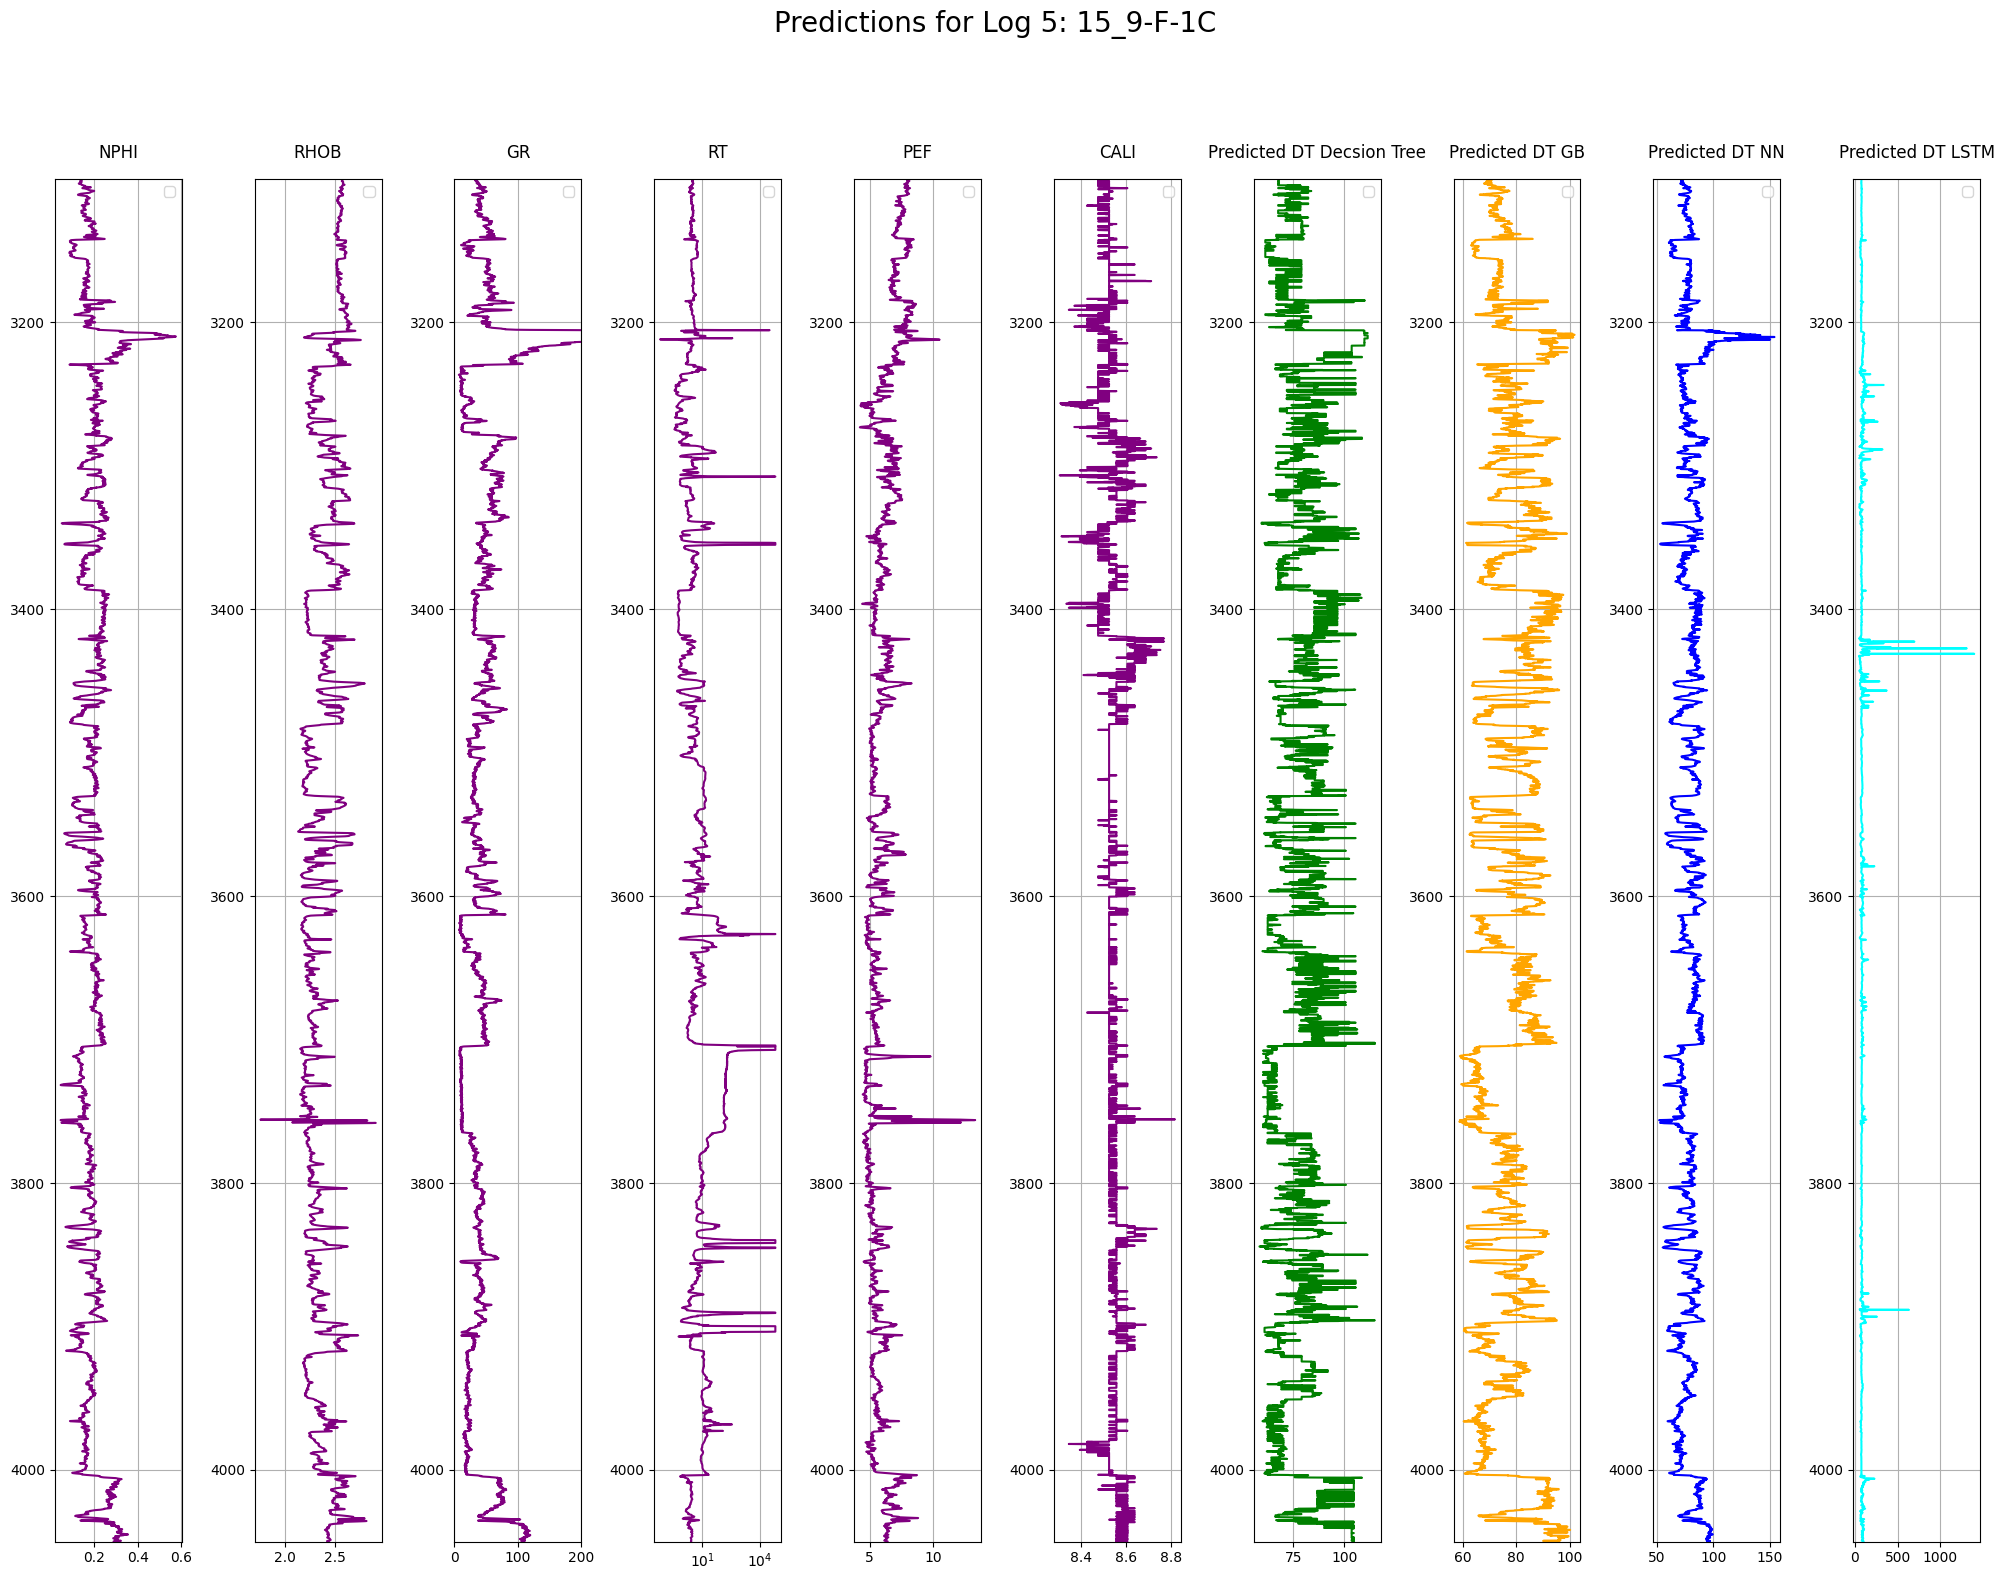

In [61]:
makeplotpred(log5,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'cyan'],
             suptitle_str="Predictions for Log 5: 15_9-F-1C")